# Bộ dữ liệu



- **Bộ dữ liệu được sử dụng**: [Link Google Drive](https://drive.google.com/file/d/14gsJbCfE_KCCmZzibXdyyNV_N4fXbZEq/view?usp=drive_link)
- **Mô tả**: Bộ dữ liệu gồm 5960 bản ghi với 13 trường dữ liệu. Mỗi bản ghi đại diện cho thông tin khách hàng có thẻ tín dụng ở ngân hàng. Mỗi người được phân loại tín dụng tốt hay xấu dựa trên một tập thuộc tính.

- **Các trường dữ liệu**:
  - **BAD**:
    - 1: Người nộp đơn đã vỡ nợ hoặc nợ quá hạn nghiêm trọng
    - 0: Người nộp đơn đã thanh toán khoản vay
  - **LOAN**: Số tiền yêu cầu vay
  - **MORTDUE**: Số tiền nợ còn lại trên khoản thế chấp hiện tại
  - **VALUE**: Giá trị tài sản hiện tại
  - **REASON**: Lý do vay
    - DebtCon: Debt consolidation (ghép nợ)
    - HomeImp: Home improvement (sửa sang nhà cửa)
  - **JOB**: Loại công việc, bao gồm các nhóm:
    - "Office"
    - "Sales"
    - "Manager"
    - "Professional Executive"
    - "Other"
  - **YOJ**: Số năm làm việc tại công việc hiện tại
  - **DEROG**: Số lượng báo cáo vỡ nợ
  - **DELINQ**: Số hạn mức tín dụng quá hạn
  - **CLAGE**: Tuổi của hạn mức tín dụng lâu nhất tính theo tháng
  - **NINQ**: Số lượng yêu cầu tín dụng gần đây
  - **CLNO**: Số lượng hạn mức tín dụng
  - **DEBTINC**: Tỷ lệ nợ/thu nhập


# Thư viện

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from sklearn.model_selection import GridSearchCV,cross_val_predict,cross_validate
from sklearn.metrics import make_scorer, RocCurveDisplay
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.metrics import specificity_score
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import pickle

In [ ]:
%matplotlib inline

# Đọc dữ liệu

In [ ]:
df = pd.read_csv("G:\\APACHE_AIRFLOW\\data\\hmeq.csv")
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


In [ ]:
df.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


Bộ dữ liệu gồm 13 cột và 5960 hàng, trong đó:
- BAD là biến mục tiêu để xác định xem khách hàng có vỡ nợ hay không.
- **Các trường phân loại**: JOB, REASON. (2)
- **Các trường kiểu số**: LOAN, MORTDUE, VALUE, YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC. (10)
- **Các trường bị thiếu dữ liệu**: MORTDUE, VALUE,REASON, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC.(11)

In [ ]:
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


Nhận xét:
- Trường **BAD** có giá trị trung bình là 0.2
- Trường **LOAN** biểu diễn số tiền khách hàng yêu cầu vay có giá trị trung bình 18.608
- Trường **MORTDUE** mô tả số tiền nợ còn lại trên khoản thế chấp còn lại có giá trị trung bình là 73760.82.
- Trường **VALUE** biểu thị giá trị tài sản hiện tại của khách hàng có giá trị trung bình là 101776
- Trường **YOJ** biểu diễn số năm kinh nghiệm trong công việc khách hàng, trung bình mỗi khách hàng có 8.92 năm kinh nghiệm
- Trường **DEROG** mô tả số lượng báo cáo vỡ nợ, trung bình mỗi khách hàng có khoảng 0.25 báo cáo vỡ nợ
- Trường **DELINQ** biểu thị số hạn mức tín dụng quá hạn, trung bình có 0.45 hạn mức tín dụng quá hạn
- Trường **CLAGE** mô tả tuổi của hạn mức tín dụng lâu nhất, có giá trị trung bình là 179.76 tháng
- Trường **NINQ** biểu diễn số lượng yêu cầu tín dụng gần đây, trung bình có khoảng 1.2 yêu cầu tín dụng gần nhất
- Trường **CLNO** biểu diễn số lượng hạn mức tín dụng trong lịch sử khách hàng, trung bình lượng hạn mức tín dụng trong lịch sử khách hàng là khoảng 21.3
- Trường **DEBTINC** biểu thị tỷ lệ nợ trên thu nhập khách hàng với giá trị trung bình là 33.79

In [ ]:
df['JOB'].value_counts()

,count
JOB,
Other,2388
ProfExe,1276
Office,948
Mgr,767
Self,193
Sales,109


Trường **JOB** mô tả nghề nghiệp của khách hàng, gồm 6 kiểu công việc: **Sales, Self, Mgr, Office, ProfExe, Other**. Trong đó chiếm số lượng đông đảo nhất là ProfExe với 1276 bản ghi, chiếm 22,35%.

In [ ]:
df['REASON'].value_counts()

,count
REASON,
DebtCon,3928
HomeImp,1780


Trường Reason là lý do vay tiền, gồm 2 lý do chính: DebtCon và HomeImp trong đó DebtCon chiếm 68.81% trong bộ dữ liệu với 3928 bản ghi.


# Chia dữ liệu thành 2 tập train và test

In [ ]:
X = df.drop(['BAD'],axis=1)  # x là các biến quan sát, lược bỏ cột BAD
y = df['BAD'] # các giá trị cột BAD là biến mục tiêu
x_train, x_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42, test_size=0.2)

In [ ]:
print("Train:",x_train.shape)
print("Test:",x_test.shape)

Train: (4768, 12)
Test: (1192, 12)


In [ ]:
y_train.value_counts()

,count
BAD,
0,3817
1,951


In [ ]:
y_test.value_counts()

,count
BAD,
0,954
1,238


# Đánh giá phân bố bộ dữ liệu

In [ ]:
def distribution_numerical_type(column):
    plt.figure(figsize=(10, 6))

    # Vẽ histogram cho tập train
    sns.histplot(x_train[column], bins=10, kde=True, color='blue', label='Train', stat='density')
    skew_train = x_train[column].skew()
    plt.text(0.95, 0.85, f"Skewness (Train): {skew_train:.2f}", transform=plt.gca().transAxes,
             horizontalalignment='right', fontsize=12, color='blue')

    # Vẽ histogram cho tập test
    sns.histplot(x_test[column], bins=10, kde=True, color='red', label='Test', stat='density')
    skew_test = x_test[column].skew()
    plt.text(0.95, 0.80, f"Skewness (Test): {skew_test:.2f}", transform=plt.gca().transAxes,
             horizontalalignment='right', fontsize=12, color='red')

    plt.xlabel(column)
    plt.ylabel('Mật độ')
    plt.legend(loc='upper right')

    plt.show()

In [ ]:
def distribution_categorical_type(column, train_data, test_data):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

    # Vẽ biểu đồ bar plot cho tập train
    train_counts = train_data.value_counts(normalize=True)
    train_counts_absolute = train_data.value_counts()
    sns.barplot(x=train_counts.index, y=train_counts.values, ax=axes[0], palette='Blues_d')
    axes[0].set_title(f"Phân phối của {column} trên tập train")
    axes[0].set_ylabel("Tần suất (Normalized)")
    axes[0].set_xlabel(column)
    for p, count in zip(axes[0].patches, train_counts_absolute):
        axes[0].annotate(f"{p.get_height():.2f}\n({count})",
                         (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                         ha='center', va='center',
                         xytext=(0, 10), textcoords='offset points', color='black', fontsize=12)

    # Vẽ biểu đồ bar plot cho tập test
    test_counts = test_data.value_counts(normalize=True)
    test_counts_absolute = test_data.value_counts()
    sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[1], palette='Reds_d')
    axes[1].set_title(f"Phân phối của {column} trên tập test")
    axes[1].set_ylabel("Tần suất (Normalized)")
    axes[1].set_xlabel(column)
    for p, count in zip(axes[1].patches, test_counts_absolute):
        axes[1].annotate(f"{p.get_height():.2f}\n({count})",
                         (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                         ha='center', va='center',
                         xytext=(0, 10), textcoords='offset points', color='black', fontsize=12)

    plt.tight_layout()
    plt.show()

<ipython-input-15-3622173a1db2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index, y=train_counts.values, ax=axes[0], palette='Blues_d')
<ipython-input-15-3622173a1db2>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[1], palette='Reds_d')


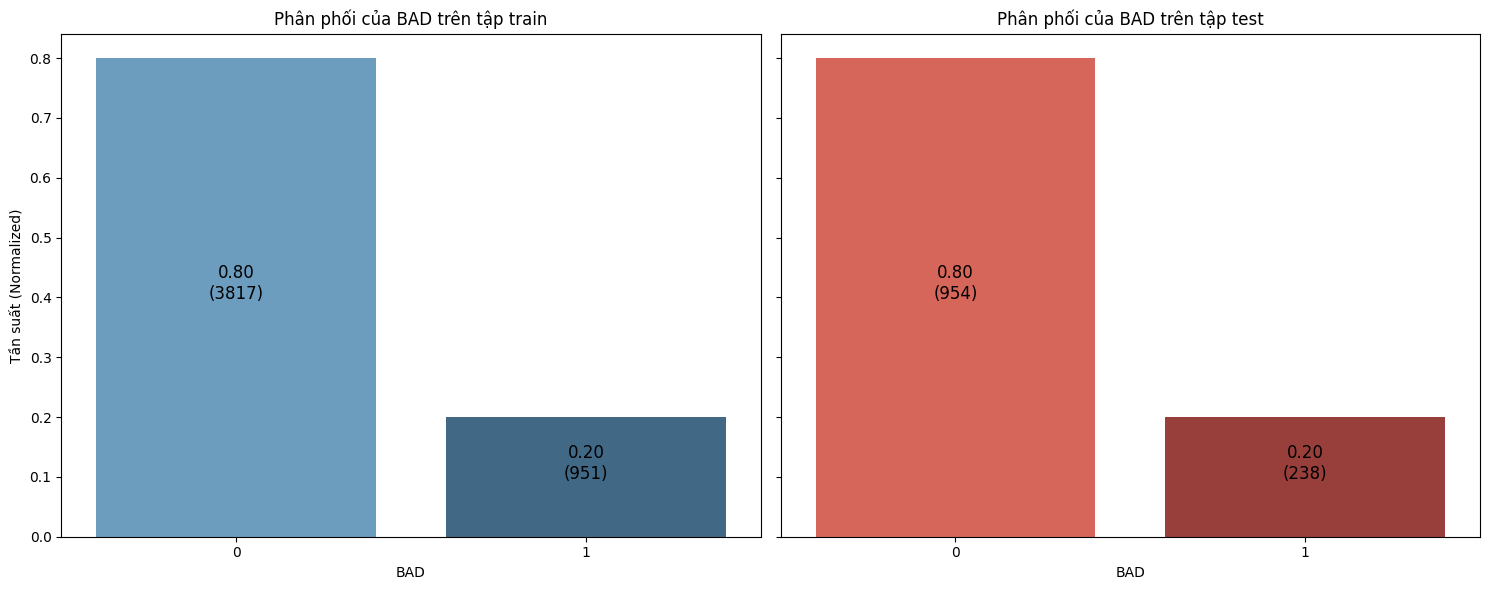

In [ ]:
distribution_categorical_type('BAD',y_train,y_test)
# Dữ liệu cột BAD loại 0 chiếm 80%
# Dữ liệu cột BAD loại 1 chiếm 20%
# Nhận xét: Phân bố dữ liệu 2 tập train và test trường BAD đồng đều

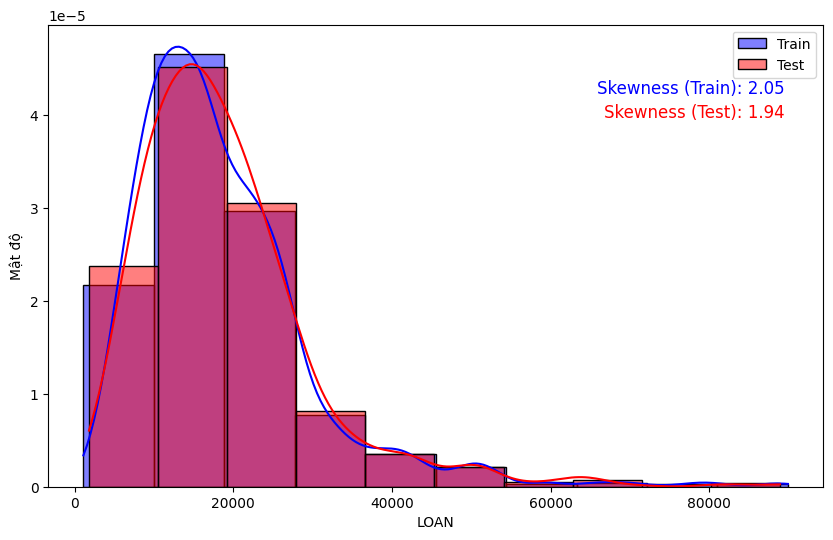

In [ ]:
distribution_numerical_type('LOAN')
# Cột LOAN ở tập train và tập test đều có xu hướng lệch phải, trong đó khoảng 10000 - 20000 tập trung nhiều dữ liệu nhất

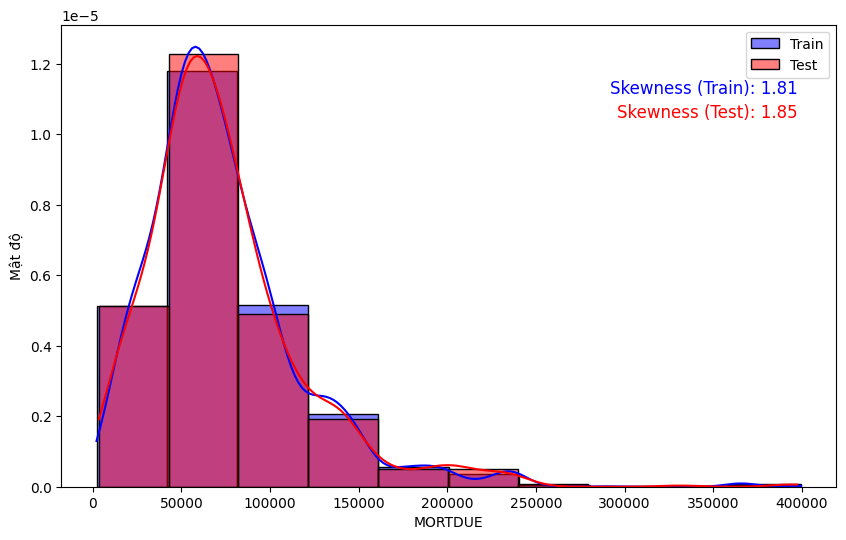

In [ ]:
distribution_numerical_type('MORTDUE')
 # Cột MORTDUE ở tập train và tập test đều có xu hướng lệch phải, trong đó khoảng xung quanh 50000 tập trung nhiều dữ liệu nhất

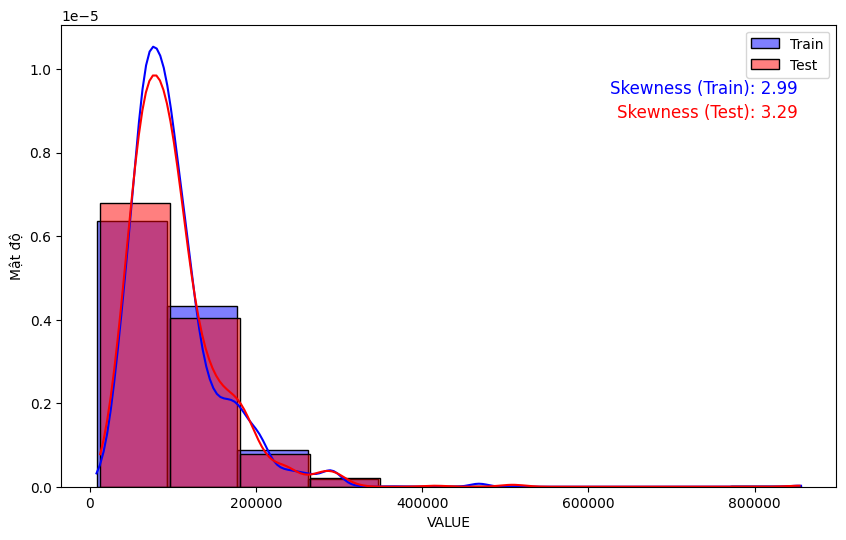

In [ ]:
distribution_numerical_type('VALUE')

# Cột VALUE ở tập train và tập test đều có xu hướng lệch phải,
# đặc biệt giá trị Skew của cả hai tập đều rất cao (trung bình là 3) cho thấy sự lệch phải rất mạnh ở tập này. Suy đoán, dữ liệu có bất thường
# Các vị trí phân bố trùng nhau giữa tập train và test có màu hồng nhạt

<ipython-input-15-3622173a1db2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index, y=train_counts.values, ax=axes[0], palette='Blues_d')
<ipython-input-15-3622173a1db2>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[1], palette='Reds_d')


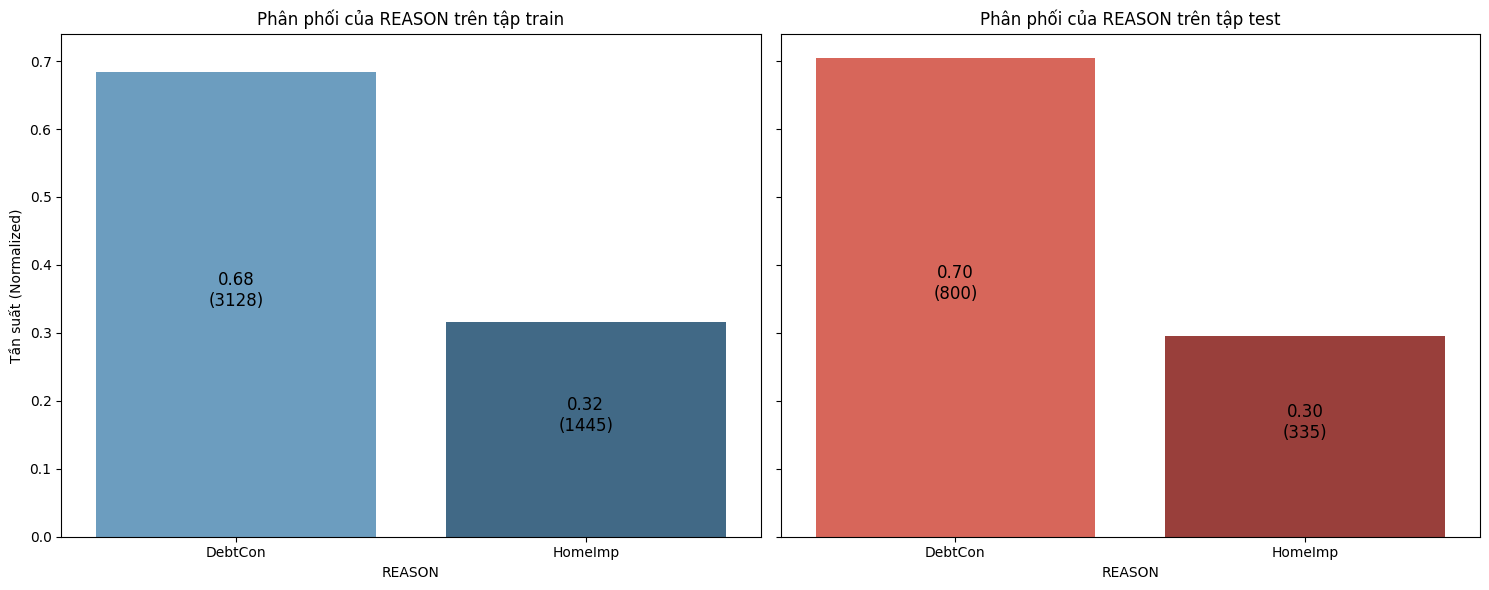

In [ ]:
distribution_categorical_type('REASON',x_train['REASON'],x_test['REASON'])
# Ở cả hai tập train và test, nhu cầu vay để ghép nợ (DebtCon) chiếm tới 70%

Mặc dù có sự chênh lệch nhỏ trong phân phối của biến DebtCon và HomeImp giữa tập train và tập test (DebtCon chiếm 68% trong tập train và 70% trong tập test; HomeImp chiếm 32% trong tập train và 30% trong tập test), sự khác biệt này là không đáng kể. Do đó, phân phối này không ảnh hưởng lớn đến quá trình huấn luyện và đánh giá mô hình, đảm bảo tính đại diện của dữ liệu giữa hai tập

<ipython-input-15-3622173a1db2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index, y=train_counts.values, ax=axes[0], palette='Blues_d')
<ipython-input-15-3622173a1db2>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[1], palette='Reds_d')


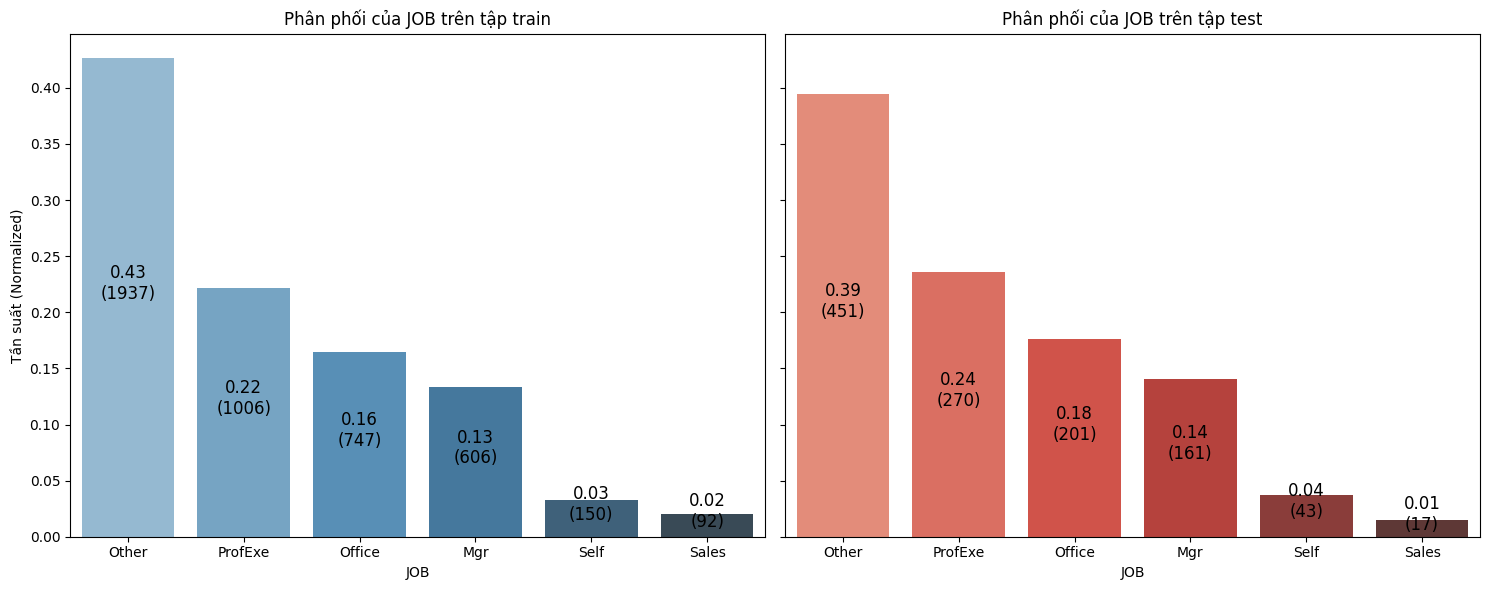

In [ ]:
distribution_categorical_type('JOB',x_train['JOB'],x_test['JOB'])
# Phân bố dữ liệu ở cả hai tập gần tương đồng nhau

Phân phối của biến JOB giữa tập train và tập test có một số khác biệt nhỏ. Chẳng hạn, nhóm công việc chiếm tỷ lệ cao nhất trong cả hai tập, với 43% trong tập train và 39% trong tập test. Các nhóm công việc khác cũng có sự chênh lệch nhưng không đáng kể (ví dụ: nhóm chiếm 22% trong tập train và 24% trong tập test). Những khác biệt này là nhỏ và không có khả năng ảnh hưởng đáng kể đến tính đại diện của dữ liệu cũng như hiệu suất tổng thể của mô hình khi dự đoán trên tập test.

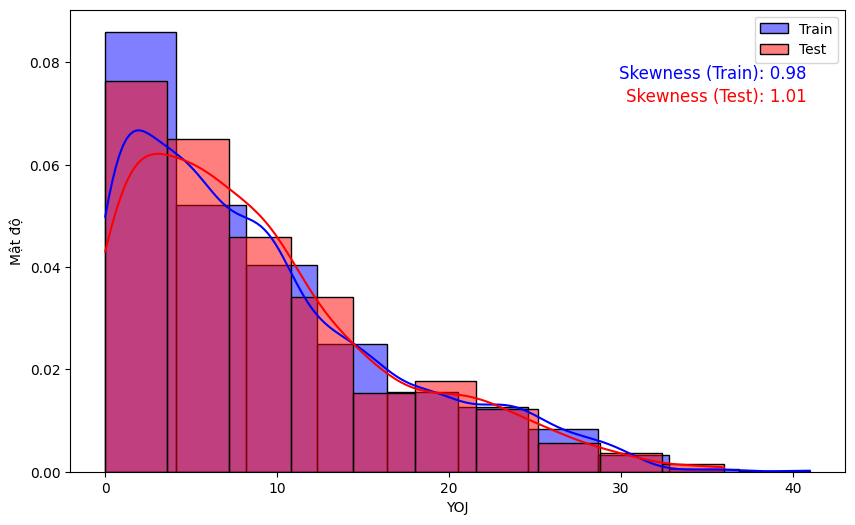

In [ ]:
distribution_numerical_type('YOJ')
# Cả hai bộ dữ liệu có phân phối tương đồng nhau, lệch phải, khoảng 0 - 3 năm tập trung nhiều dữ liệu nhất
# Các vị trí phân bố trùng nhau giữa tập train và test có màu hồng nhạt

<ipython-input-15-3622173a1db2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index, y=train_counts.values, ax=axes[0], palette='Blues_d')
<ipython-input-15-3622173a1db2>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[1], palette='Reds_d')


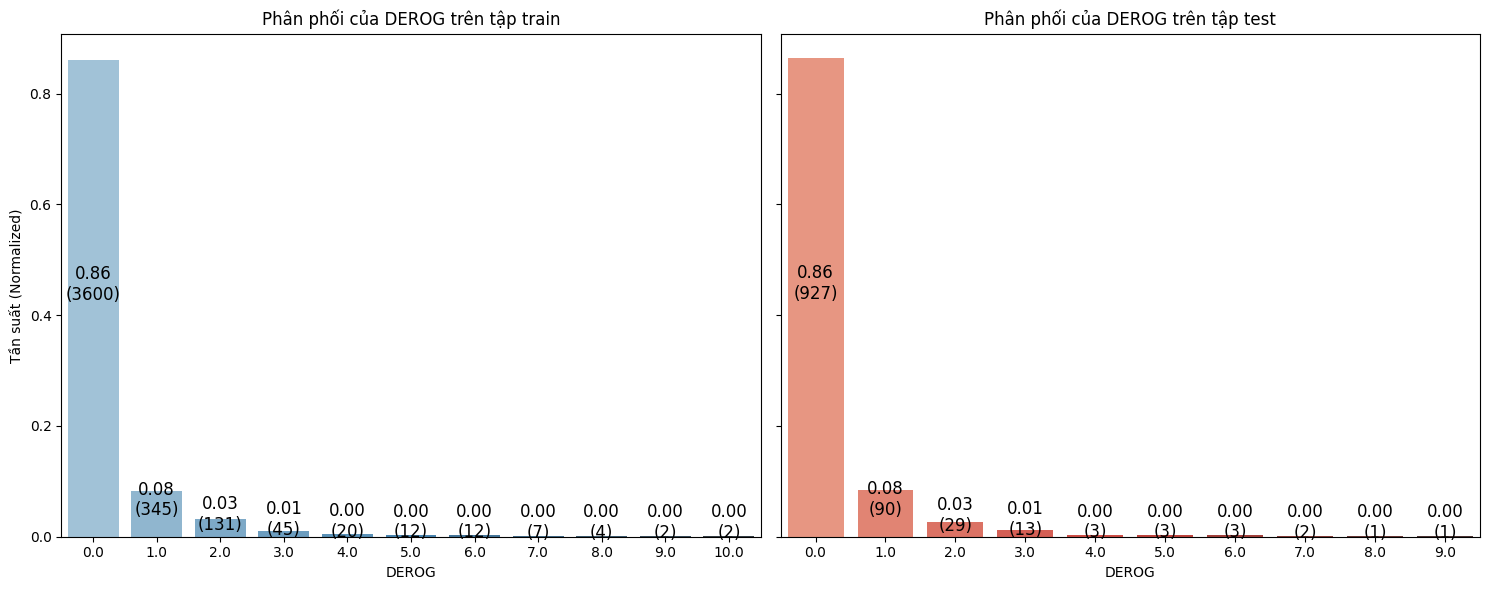

In [ ]:
distribution_categorical_type('DEROG',x_train['DEROG'],x_test['DEROG'])
# 0 số lượng báo cáo vỡ nợ chiếm 86% cao nhất ở cả 2 tập train và test
# Phân bố bộ dữ liệu đồng đều trên cả 2 tập train và test

<ipython-input-15-3622173a1db2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index, y=train_counts.values, ax=axes[0], palette='Blues_d')
<ipython-input-15-3622173a1db2>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[1], palette='Reds_d')


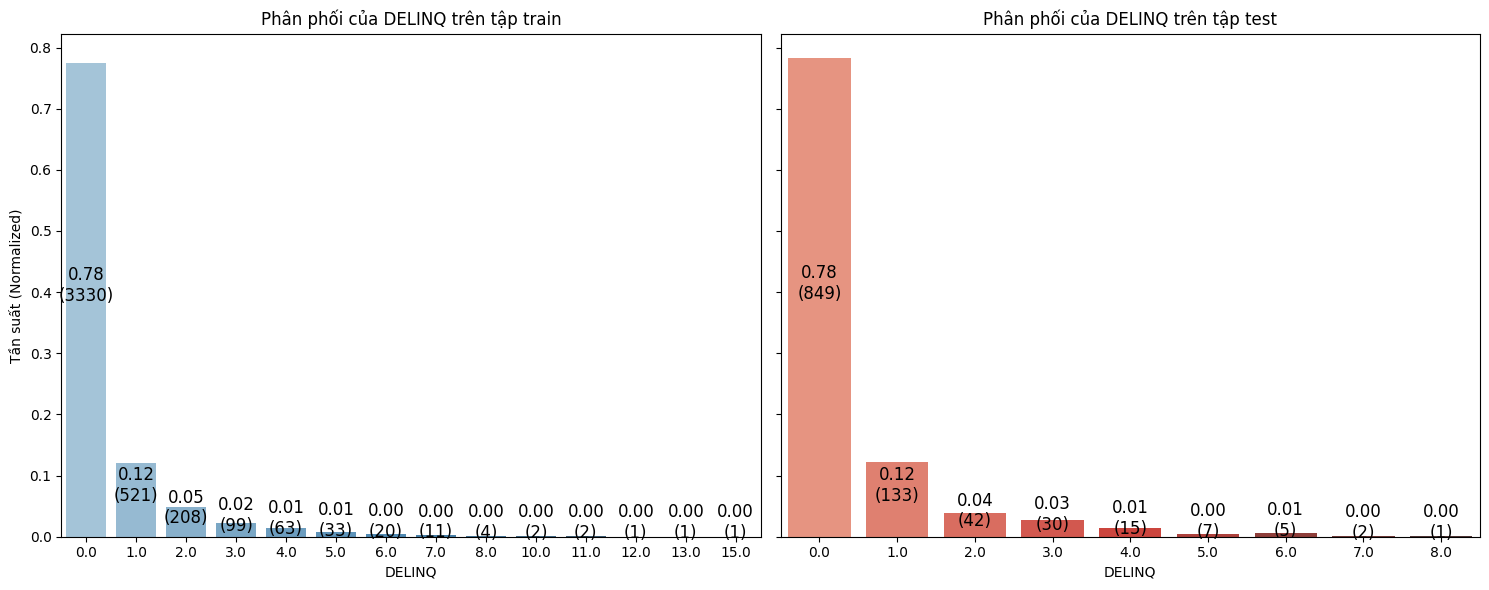

In [ ]:
distribution_categorical_type("DELINQ", x_train["DELINQ"], x_test["DELINQ"])
# 0 số lượng tín dụng quá hạn chiếm 78% cao nhất ở cả tập train và test

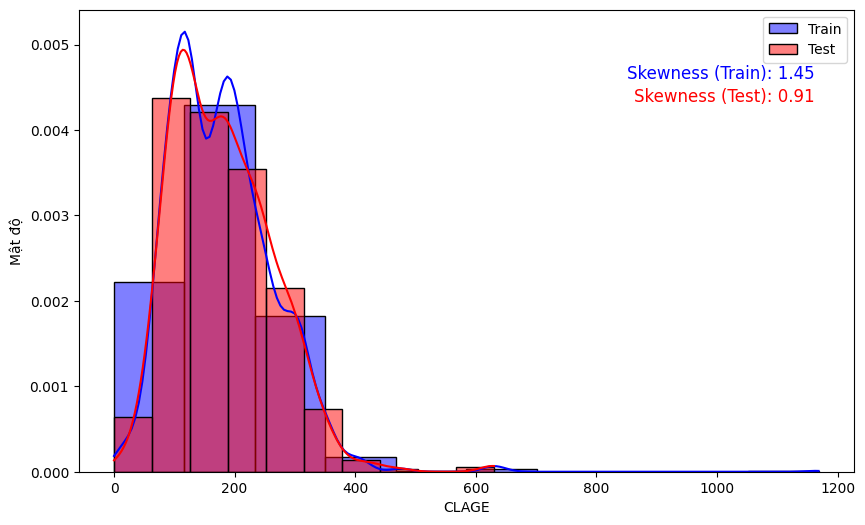

In [ ]:
distribution_numerical_type('CLAGE')
# Dữ liệu cột CLAGE (tuổi thọ tín dụng cao nhất) ở cả 2 tập train và test đều lệch phải, đạt đỉnh trong khoảng 0-200
# Các vị trí phân bố trùng nhau giữa tập train và test có màu hồng nhạt

<ipython-input-15-3622173a1db2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index, y=train_counts.values, ax=axes[0], palette='Blues_d')
<ipython-input-15-3622173a1db2>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[1], palette='Reds_d')


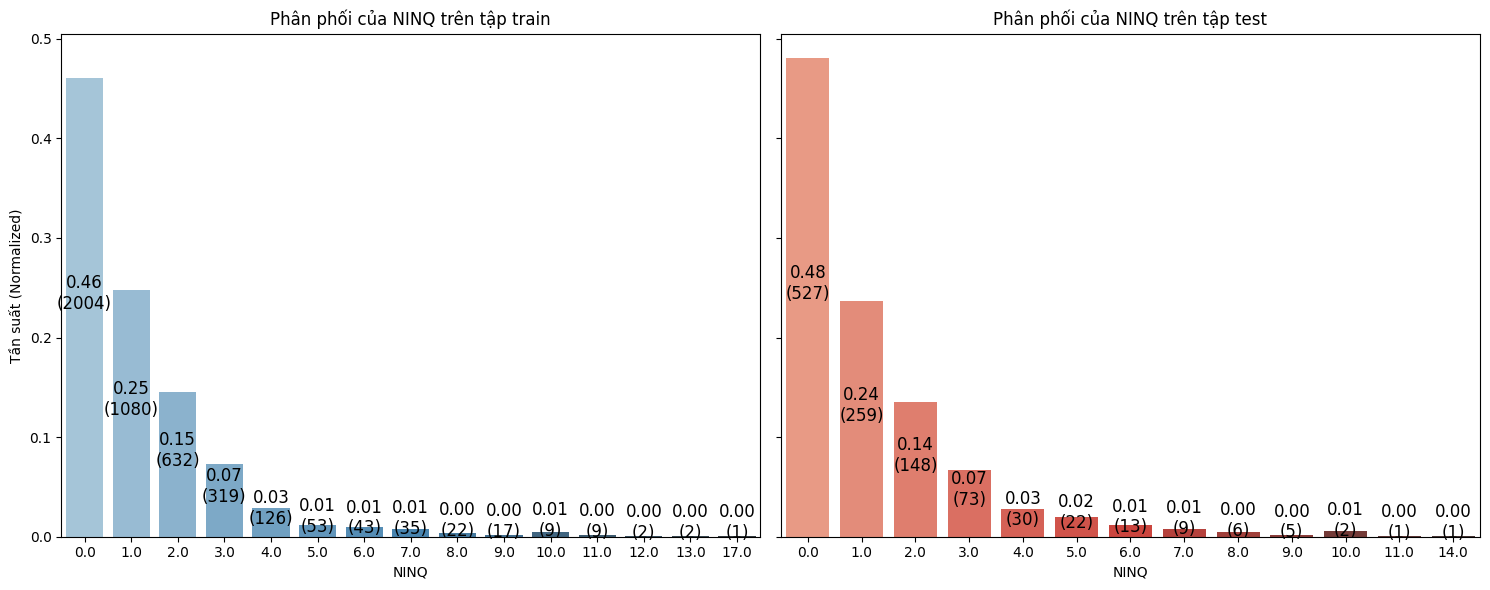

In [ ]:
distribution_categorical_type("NINQ", x_train["NINQ"], x_test["NINQ"])
# 0 yêu cầu tín dụng gần đây chiếm 46-48% cao nhất trên 2 tập train và test

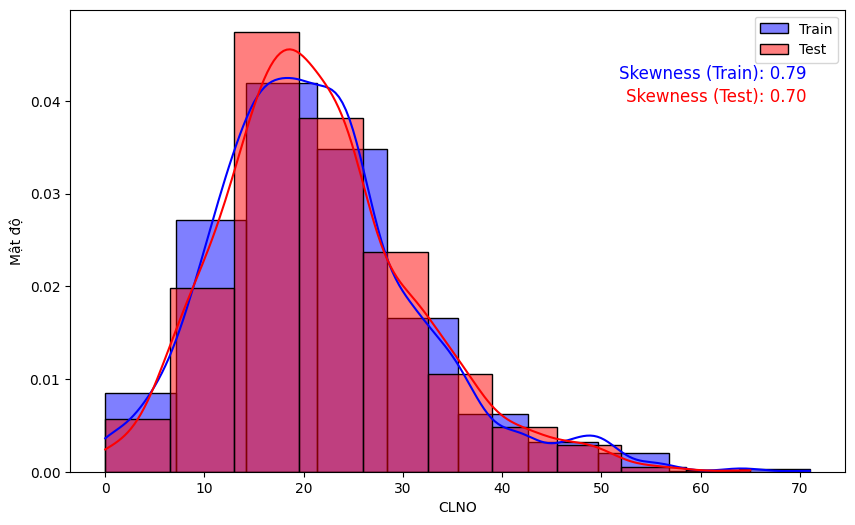

In [ ]:
distribution_numerical_type('CLNO')
# Phân bố hai tập train và test khá đối xứng nhưng vẫn có xu hướng lệch phải nhẹ
# Các vị trí phân bố trùng nhau giữa tập train và test có màu hồng nhạt

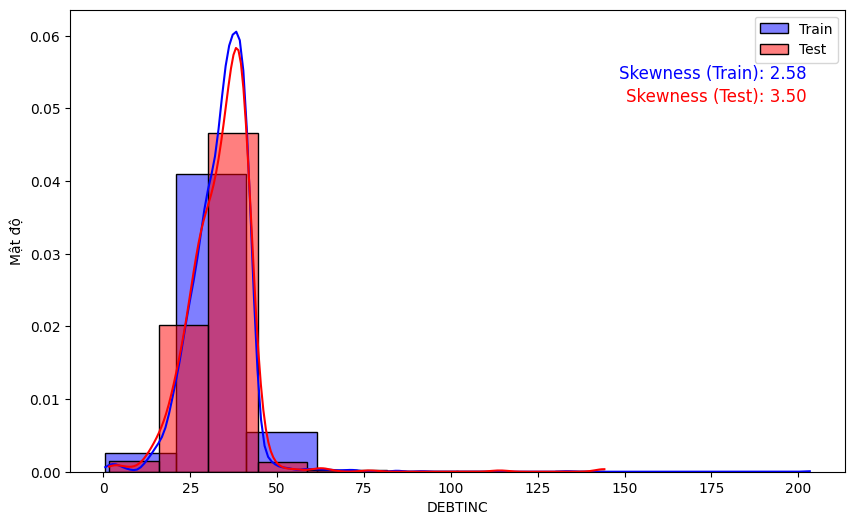

In [ ]:
distribution_numerical_type('DEBTINC')
# Cả hai tập train và test đều xó bị lệch hẳn sang phải (skew xấp xỉ 3), trong đó tập trung nhiều dữ liệu trong khoảng 25-50
# Suy đoán: bộ dữ liệu có bất thường
# Các vị trí phân bố trùng nhau giữa tập train và test có màu hồng nhạt

<p>Kết luận</p>
<p>- Đa số phân bố các trường định lượng có xu hướng lệch phải</p>
<p>- Các trường định tính đều có xu hướng trội hẳn ở 1-2 danh mục. </p>
<p>LOAN: Cột 'LOAN'  bị lệch phải (skewness = 2.06 và skewness = 1.95) ở cả hai tập train và tập test.</p>
<p>MORTDUE: Cột 'MORTDUE' bị lệch sang phải (skewness = 1.87 và skewness = 1.67) ở cả hai tập train và tập test.</p>
<p>VALUE: Cột 'VALUE' bị lệch hẳn về bên phải (skewness = 3.13 và skewness = 2.86) ở cả hai tập train và tập test.</p>
<p>YOJ: Cột 'YOJ' dường như bị lệch về bên phải (skewness = 0.99 và skewness = 0.99) ở cả hai tập train và tập test.</p>
<p>CLAGE: Cột 'CLAGE' dường như bị lệch sang phải (skewness = 1.51 và skewness = 0.94) ở cả hai tập train và tập test.</p>
<p>CLNO: Cột 'CLNO' dường như bị lệch sang phải (skewness = 0.8 và skewness = 0.71) ở cả hai tập train và tập test.</p>
<p>DEBTINC: Cột 'DEBTINC' (skewness = 2.59 và skewness = 3.24) bị lệch hẳn sang phải ở cả hai tập train và test.</p>


# Mối tương quan giữa các trường dữ liệu

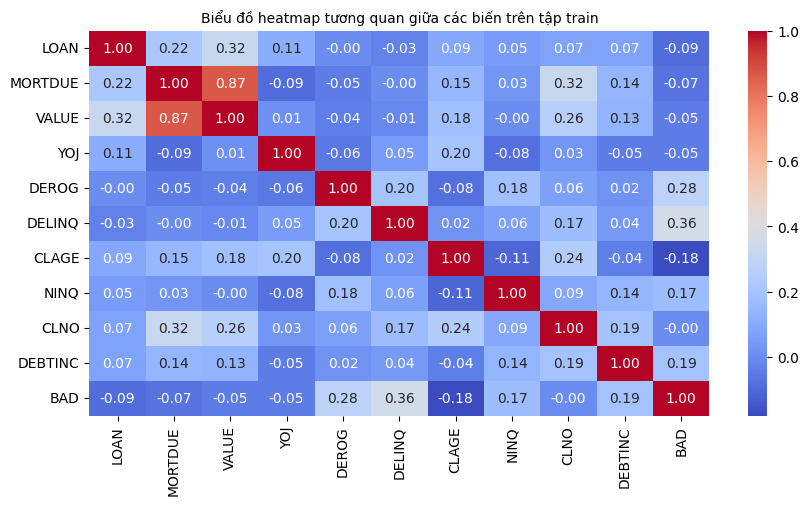

In [ ]:
data_corr = x_train.copy()
data_corr["BAD"] = y_train
data_corr = data_corr.drop(['JOB', 'REASON'], axis=1)
plt.figure(figsize=(10,5))
# Tạo ma trận tương quan
corr_matrix = round(data_corr.corr(),2)

# Vẽ biểu đồ heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})

plt.title("Biểu đồ heatmap tương quan giữa các biến trên tập train",fontsize=10)

plt.show()

Dựa trên biểu đồ heatmap tương quan giữa nhãn `BAD` và các đặc trưng còn lại:

- Nhãn `BAD` có mối tương quan dương (mức độ tương quan thấp) với các biến `DEROG` (0.28), `DELINQ` (0.36),`DEBTINC` (0.19),`NINQ` (0.17). Điều này cho thấy rằng khi các giá trị của `DEROG`, `DELINQ`,`NINQ` và `DEBTINC` tăng, khả năng một khách hàng có nguy cơ vỡ nợ (`BAD = 1`) cũng tăng lên.
  
- Ngược lại, `BAD` có mối tương quan âm nhẹ với các biến `LOAN` (-0.09), `MORTDUE` (-0.07), `VALUE` (-0.05), `CLAGE` (-0.18), và `YOJ` (-0.05). Điều này cho thấy rằng khi giá trị của các biến này tăng, khả năng khách hàng vỡ nợ có xu hướng giảm, nhưng mức độ ảnh hưởng không lớn.

- Biến `CLNO` có mối tương quan gần như bằng 0 với `BAD`, cho thấy rằng biến này không có mối liên hệ rõ ràng với việc khách hàng có rủi ro vỡ nợ hay không.

Nhìn chung, sự tương quan giữa nhãn `BAD` và các đặc trưng còn lại là tương đối yếu. Tuy nhiên, các đặc trưng như `DEROG`, `DELINQ`, `DEBTINC`, và `NINQ` có mối tương quan dương đáng chú ý, có thể đóng vai trò quan trọng trong việc dự đoán khả năng vỡ nợ của khách hàng.


# TƯƠNG QUAN GIỮA CÁC BIẾN VÀ BIẾN DỰ ĐOÁN (BAD)

In [ ]:
def plot_crosstab(data, feature, target, ax, title):
    crosstab = pd.crosstab(data[feature], data[target])
    crosstab.div(crosstab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, ax=ax, title=title,color=['blue','pink'])

def relationship_variable_with_target(data):
    # Tạo các subplot
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
    fig.suptitle("Relationships between 'BAD' and Different Features", fontsize=16)

    # Danh sách các tính năng và tiêu đề tương ứng
    features = ['REASON', 'JOB', 'DEROG', 'DELINQ', 'NINQ']
    titles = ['REASON vs BAD', 'JOB vs BAD', 'DEROG vs BAD', 'DELINQ vs BAD', 'NINQ vs BAD']

    # Vẽ các biểu đồ cho các tính năng
    for feature, title, ax in zip(features, titles, axes.flatten()[:5]):
        plot_crosstab(data, feature, 'BAD', ax, title)

    # Xử lý đặc biệt cho 'DEBTINC'
    bins = [0, 40, 100, 204]
    group = ['Low', 'Average', 'High']
    data['DEBTINC_bin'] = pd.cut(data['DEBTINC'], bins, labels=group)
    plot_crosstab(data, 'DEBTINC_bin', 'BAD', axes[2, 1], 'DEBTINC vs BAD')
    axes[2, 1].set_xlabel('DEBTINC')

    # Điều chỉnh bố cục và hiển thị các biểu đồ
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


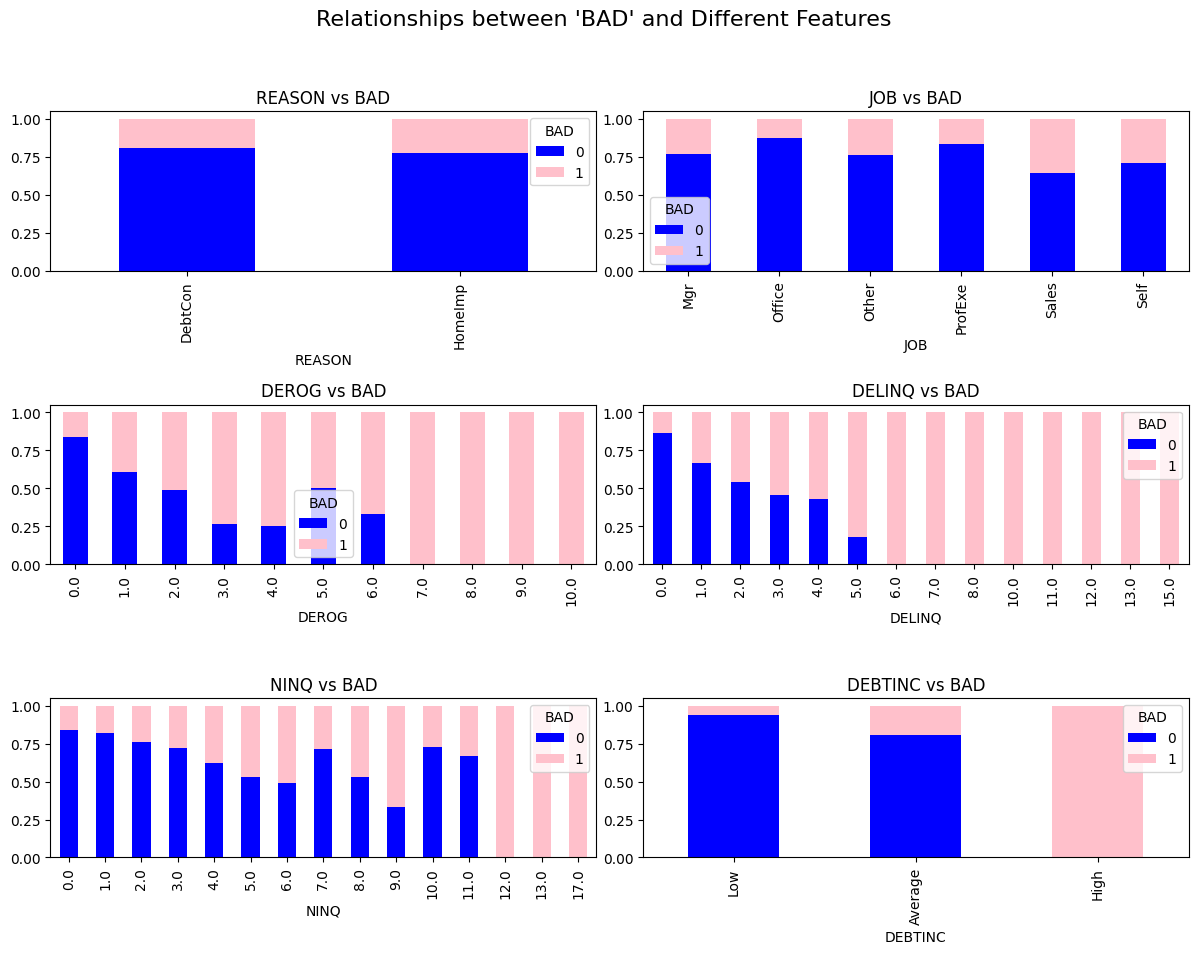

In [ ]:
data_corr = x_train.copy()
data_corr["BAD"] = y_train
relationship_variable_with_target(data_corr)

<p>Nhận xét: </p>
<p>Các biểu đồ trên cho thấy sự phụ thuộc của biến dự đoán (BAD) vào các biến khác có tính tương quan cao với biến dự đoán: <mark>JOB</mark>, <mark>REASON</mark>, <mark>DEROG</mark>, <mark>DELINQ</mark>, <mark>NINQ</mark>, <mark>DEBTINC</mark>.</p>

<p>- Phần trăm vỡ nợ do HomeImp cao hơn phần trăm vỡ nợ do DebtCon.
<p>- Phần trăm vỡ nợ với khách hàng làm ngành Sales cao nhất và phần trăm vỡ nợ khi làm các công việc khác là thấp nhất
<p>- Lượng báo cáo vỡ nợ (DEROG) càng lớn thì khả năng vỡ nợ càng cao, đặc biệt với số lượng báo cáo từ 7 trở lên đạt 100% khả năng vỡ nợ.
<p>- Số hạn mức tín dụng quá hạn (DELINQ) càng lớn thì khả năng vỡ nợ càng cao, đặc biệt với số hạn mức tín dụng quá hạn từ 7 trở lên đạt 100% khả năng vỡ nợ.
<p>- Lượng yêu cầu tín dụng (NINQ) càng lớn thì khả năng vỡ nợ càng cao, đặc biệt với lượng yêu cầu tín dụng từ 12 trở lên đạt 100% khả năng vỡ nợ.
<p>- Tỉ lệ (nợ/thu nhập) - DEBTINC càng lớn, nghĩa số tiền nợ hàng tháng phải trả quá cao so với mức lương thu nhập thì khả năng vỡ nợ càng cao, đặc biệt con số này đạt 100% thì có 100% khả năng vỡ nợ.

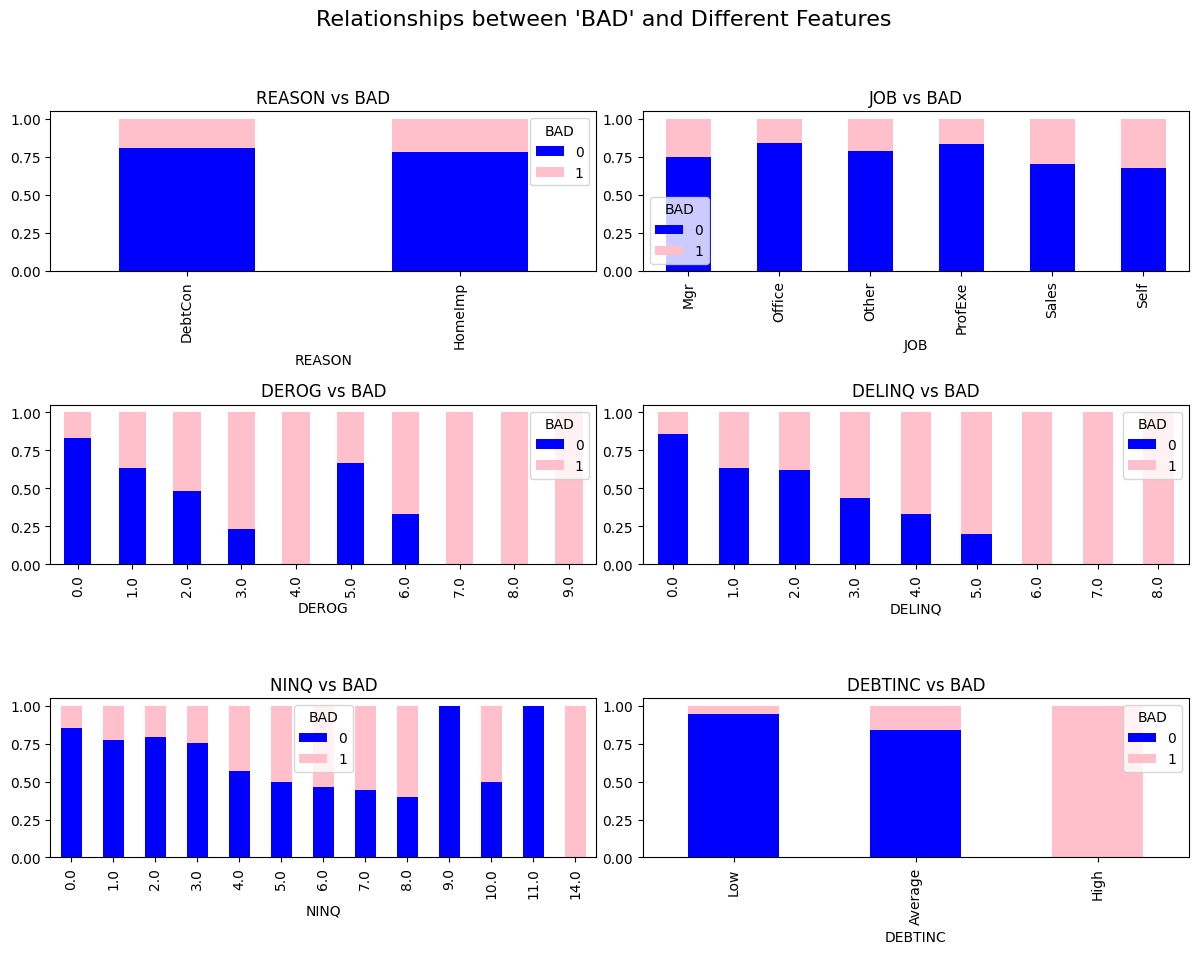

In [ ]:
data_corr_test = x_test.copy()
data_corr_test["BAD"] = y_test
relationship_variable_with_target(data_corr_test)

<p>Nhận xét: </p>
<p>- Nhìn chung, mối liên hệ giữa biến dự đoán và các biến khác ở tập test gần tương đồng với tập train </p>
<p>- Tuy nhiên, trong biểu đồ tương quan giữa BAD và JOB, người làm nghề Self có khả năng vỡ nợ cao nhất và Office có khả năng vỡ nợ ít nhất </p>

# Tiền xử lý dữ liệu

In [ ]:
# Kiểm tra bộ dữ liệu có dữ liệu trùng lặp hay không
print("Có dữ liệu trùng lặp trên tập train không? ", x_train.duplicated().any())
print("Có dữ liệu trùng lặp trên tập test không? ", x_test.duplicated().any())

Có dữ liệu trùng lặp trên tập train không?  False
Có dữ liệu trùng lặp trên tập test không?  False


In [ ]:
# Kiểm tra bao nhiêu trường dữ liệu có dữ liệu NaN
print("Số giá trị NaN ở từng trường dữ liệu trên tập train:")
print(x_train.isna().sum(), "\n")
print("Số giá trị NaN ở từng trường dữ liệu trên tập test:")
print(x_test.isna().sum())

Số giá trị NaN ở từng trường dữ liệu trên tập train:
LOAN          0
MORTDUE     421
VALUE        89
REASON      195
JOB         230
YOJ         403
DEROG       588
DELINQ      472
CLAGE       259
NINQ        414
CLNO        184
DEBTINC    1005
dtype: int64 

Số giá trị NaN ở từng trường dữ liệu trên tập test:
LOAN         0
MORTDUE     97
VALUE       23
REASON      57
JOB         49
YOJ        112
DEROG      120
DELINQ     108
CLAGE       49
NINQ        96
CLNO        38
DEBTINC    262
dtype: int64


In [ ]:
# Phần trăm của giá trị NaN ở từng trường dữ liệu
print("Tỉ lệ giá trị Nan trên tập train:")
print(round((x_train.isnull().sum()/len(x_train)*100).sort_values(),2))
print("Tỉ lệ giá trị Nan trên tập test:")
print(round((x_test.isnull().sum()/len(x_test)*100).sort_values(),2))

Tỉ lệ giá trị Nan trên tập train:
LOAN        0.00
VALUE       1.87
CLNO        3.86
REASON      4.09
JOB         4.82
CLAGE       5.43
YOJ         8.45
NINQ        8.68
MORTDUE     8.83
DELINQ      9.90
DEROG      12.33
DEBTINC    21.08
dtype: float64
Tỉ lệ giá trị Nan trên tập test:
LOAN        0.00
VALUE       1.93
CLNO        3.19
JOB         4.11
CLAGE       4.11
REASON      4.78
NINQ        8.05
MORTDUE     8.14
DELINQ      9.06
YOJ         9.40
DEROG      10.07
DEBTINC    21.98
dtype: float64


<p>
  Nhận xét: Dữ liệu được cung cấp cho thấy tỉ lệ giá trị NaN trên các biến khác nhau trong tập train và tập test như sau:
</p>

<h3>Tập train:</h3>
<ul>
  <li>DEBTINC có tỉ lệ NaN cao nhất, đạt 21.08%, tiếp theo là DEROG với 12.33%.</li>
  <li>Các biến NINQ, YOJ, MORTDUE, DELINQ cũng có tỉ lệ NaN khá cao, dao động từ khoảng 8% đến gần 10%.</li>
</ul>

<h3>Tập test:</h3>
<ul>
  <li>DEBTINC tiếp tục là biến có tỉ lệ NaN cao nhất, đạt 21.98%.</li>
  <li>Các biến DEROG, DELINQ, NINQ, YOJ, MORTDUE cũng có tỉ lệ NaN tương đối cao, dao động từ khoảng 8% đến hơn 10%.</li>
</ul>

<p>
  Việc xử lý dữ liệu NaN là rất quan trọng để đảm bảo chất lượng của mô hình học máy. Đặc biệt là việc xử lý biến DEBTINC với tỉ lệ NaN rất cao có thể ảnh hưởng nghiêm trọng đến kết quả dự đoán.
</p>

Chiến lược xử lý giá trị NaN:
- Với các trường kiểu số: Điền vào các giá trị median, mean và 1 giá trị thay thế khác
- Với các trường phân loại: mode và giá trị thay thế khác

In [ ]:
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4768 entries, 609 to 2
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   LOAN     4768 non-null   int64  
 1   MORTDUE  4347 non-null   float64
 2   VALUE    4679 non-null   float64
 3   REASON   4573 non-null   object 
 4   JOB      4538 non-null   object 
 5   YOJ      4365 non-null   float64
 6   DEROG    4180 non-null   float64
 7   DELINQ   4296 non-null   float64
 8   CLAGE    4509 non-null   float64
 9   NINQ     4354 non-null   float64
 10  CLNO     4584 non-null   float64
 11  DEBTINC  3763 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 484.2+ KB
None


<p> Các chiến lược fillna như sau: </p>
<p>1. Các trường số lệch phải fill median (median ít bị ảnhh hưởng bởi giá trị ngoại lai), các trường phân loại điền vào 1 giá trị thay thế,xóa các hàng null từ 4 trở lên  (có 2/4768 hàng null từ 4 trở lên do đó số lượng dữ liệu bị mất mát không đáng kể) . </p>
<p>2. Các trường số lệch phải fill median, các trường phân loại điền vào giá trị nhiều nhất (để giữ tính chất phân phối dữ liệu), xóa các hàng null từ 4 trở lên (có 2/4768 hàng null từ 4 trở lên do đó số lượng dữ liệu bị mất mát không đáng kể) . </p>

In [ ]:
def strategy_1(x,y,is_drop=True):
    # Loại bỏ các hàng có 4 bản ghi nếu is_drop == True
    if is_drop:
        data = pd.concat([x,y],axis=1)
        data.dropna(axis = 0, thresh=3,inplace=True)
        y = data['BAD']
        x = data.drop(['BAD'],axis=1)
    for column in x.columns[1:]:
        if x[column].dtype == 'object':
            # Fill giá trị thay thế vào các cột Reason và job
            if (column == 'Reason' or column == 'JOB'):
                x.fillna('Unknown')
        else:
            # Thay thế các vị trí NA bằng giá trị trung vị xét từng trường hợp y = 0 và y=1
            x.loc[(x[column].isna()) & (y == 0), column] = round(x[y == 0][column].median(), 0)
            x.loc[(x[column].isna()) & (y == 1), column] = round(x[y == 1][column].median(), 0)
    return x,y

In [ ]:
def strategy_2(x,y,is_drop=True):
    # Loại bỏ các hàng có 4 bản ghi nếu is_drop == True
    if is_drop:
        data = pd.concat([x,y],axis=1)
        data.dropna(axis = 0, thresh=3,inplace=True)
        y = data['BAD']
        x = data.drop(['BAD'],axis=1)
    for column in x.columns[1:]:
        if x[column].dtype == 'object':
            # Fill giá trị nhiều nhất vào các cột Reason và job
            x[column].fillna(x[column].mode().iloc[0], inplace=True)
        else:
            # Thay thế các vị trí NA bằng giá trị xuất hiện nhiều nhất xét từng trường hợp y = 0 và y=1
            x.loc[(x[column].isna()) & (y == 0), column] = x[y == 0][column].value_counts().idxmax()
            x.loc[(x[column].isna()) & (y == 1), column] = x[y == 1][column].value_counts().idxmax()
    return x,y

## LABEL ENCODING

In [ ]:
def labelencoding_label(x, index, save):
    labelEncoder = LabelEncoder()
    for column in x.columns:
        if x[column].dtype == 'object':
            x[column] = labelEncoder.fit_transform(x[column])
    if save:
        pickle.dump(labelEncoder, open(f'G:\\APACHE_AIRFLOW\\model\\Credit score\\model_df{index}\\LabelEncoder.pickle', 'wb'))

## Xử lý outlier

In [ ]:
def show_outliers_boxplot(df):
    # Tạo figure và axes cho subplot
    fig, ax = plt.subplots(df.shape[1], 1, figsize=(10, 2 * df.shape[1]))

    # Duyệt qua từng cột trong DataFrame
    for i, column in enumerate(df.columns):
        ax[i].boxplot(df[column])
        ax[i].set_title(f'Boxplot of {column}')
        ax[i].set_ylabel(column)

    plt.tight_layout()
    plt.show()

In [ ]:
def remove_outliers_iqr(x, y, columns):
    df = pd.concat([x, y], axis=1)
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = ((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)
    df_final = df[~outlier_mask]

    # Split back into X and Y
    x = df_final.iloc[:, :len(x.columns)]
    y = df_final.iloc[:, len(x.columns):]

    return x, y

## Chuẩn hóa dữ liệu

In [ ]:
def standardScaler_data(X, y, index, save):
    # Ít bị ảnh hưởng bởi ngoại lệ
    # Chuẩn hóa theo Z-score
    # Trung bình = 0 và độ lệch chuẩn 1
    # Khoảng giá trị có thể có các số ngoài khoảng [0,1]
  scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
  scaled_features = scaler.fit_transform(X)

  scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
  if save:
    pickle.dump(scaler, open(f'G:\\APACHE_AIRFLOW\\model\\Credit score\\model_df{index}\StandardScaler.pickle', 'wb'))
  return scaled_features_df,y

def MinMaxScaler_data(X, y, index, save):
# Dễ bị ảnhh hưởng bởi ngoại lệ
# Giữ nguyên mối quan hệ tuyến tính giữa các biến, quy khoảng giá trị về [0,1]
  scaler = MinMaxScaler()
  scaled_features = scaler.fit_transform(X)

  scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
  if save:
    pickle.dump(scaler, open(f'G:\\APACHE_AIRFLOW\\model\\Credit score\\model_df{index}\\MinMaxScaler.pickle', 'wb'))
  return scaled_features_df,y

## Chọn lọc đặc trưng

In [ ]:
def Feature_Selection(x,y,N):
  # labelEncoder = LabelEncoder()
  # for column in x.columns:
  #   if x[column].dtype == 'object':
  #     x[column] = labelEncoder.fit_transform(x[column])
  selector = SelectKBest(score_func=chi2,k=N).fit(x,y)
  data = pd.DataFrame(selector.transform(x),columns = selector.get_feature_names_out())
  return data

## Tạo dữ liệu

### BỘ DỮ LIỆU 1: Chiến lược 1
- Không bỏ các hàng có từ 4 vị trí null trở lên
- Loại bỏ outlier
- Mã hóa nhãn biến phân loại về dạng số 
- Chuẩn hóa dữ liệu bằng Standard

In [ ]:
x_train_1, x_test_1, y_train_1, y_test_1 = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
# Không bỏ các hàng có từ 4 vị trí null trở lên và Triển khai theo chiến lược 1
x_train_1,y_train_1 = strategy_1(x_train_1,y_train_1,False)
x_test_1,y_test_1 = strategy_1(x_test_1,y_test_1,False)
# Loại bỏ ngoại lệ các cột có giá trị skew trung bình là 3
remove_outliers_iqr(x_train_1,y_train_1,['VALUE','DEBTINC'])
remove_outliers_iqr(x_test_1,y_test_1,['VALUE','DEBTINC'])
# LabelEncode
labelencoding_label(x_train_1,1,True)
labelencoding_label(x_test_1,1,False)
# Chuẩn hóa dạng Standard Scaler
x_train_1, y_train_1 = standardScaler_data(x_train_1, y_train_1, 1, True)
x_test_1, y_test_1 = standardScaler_data(x_test_1, y_test_1, 1, False)

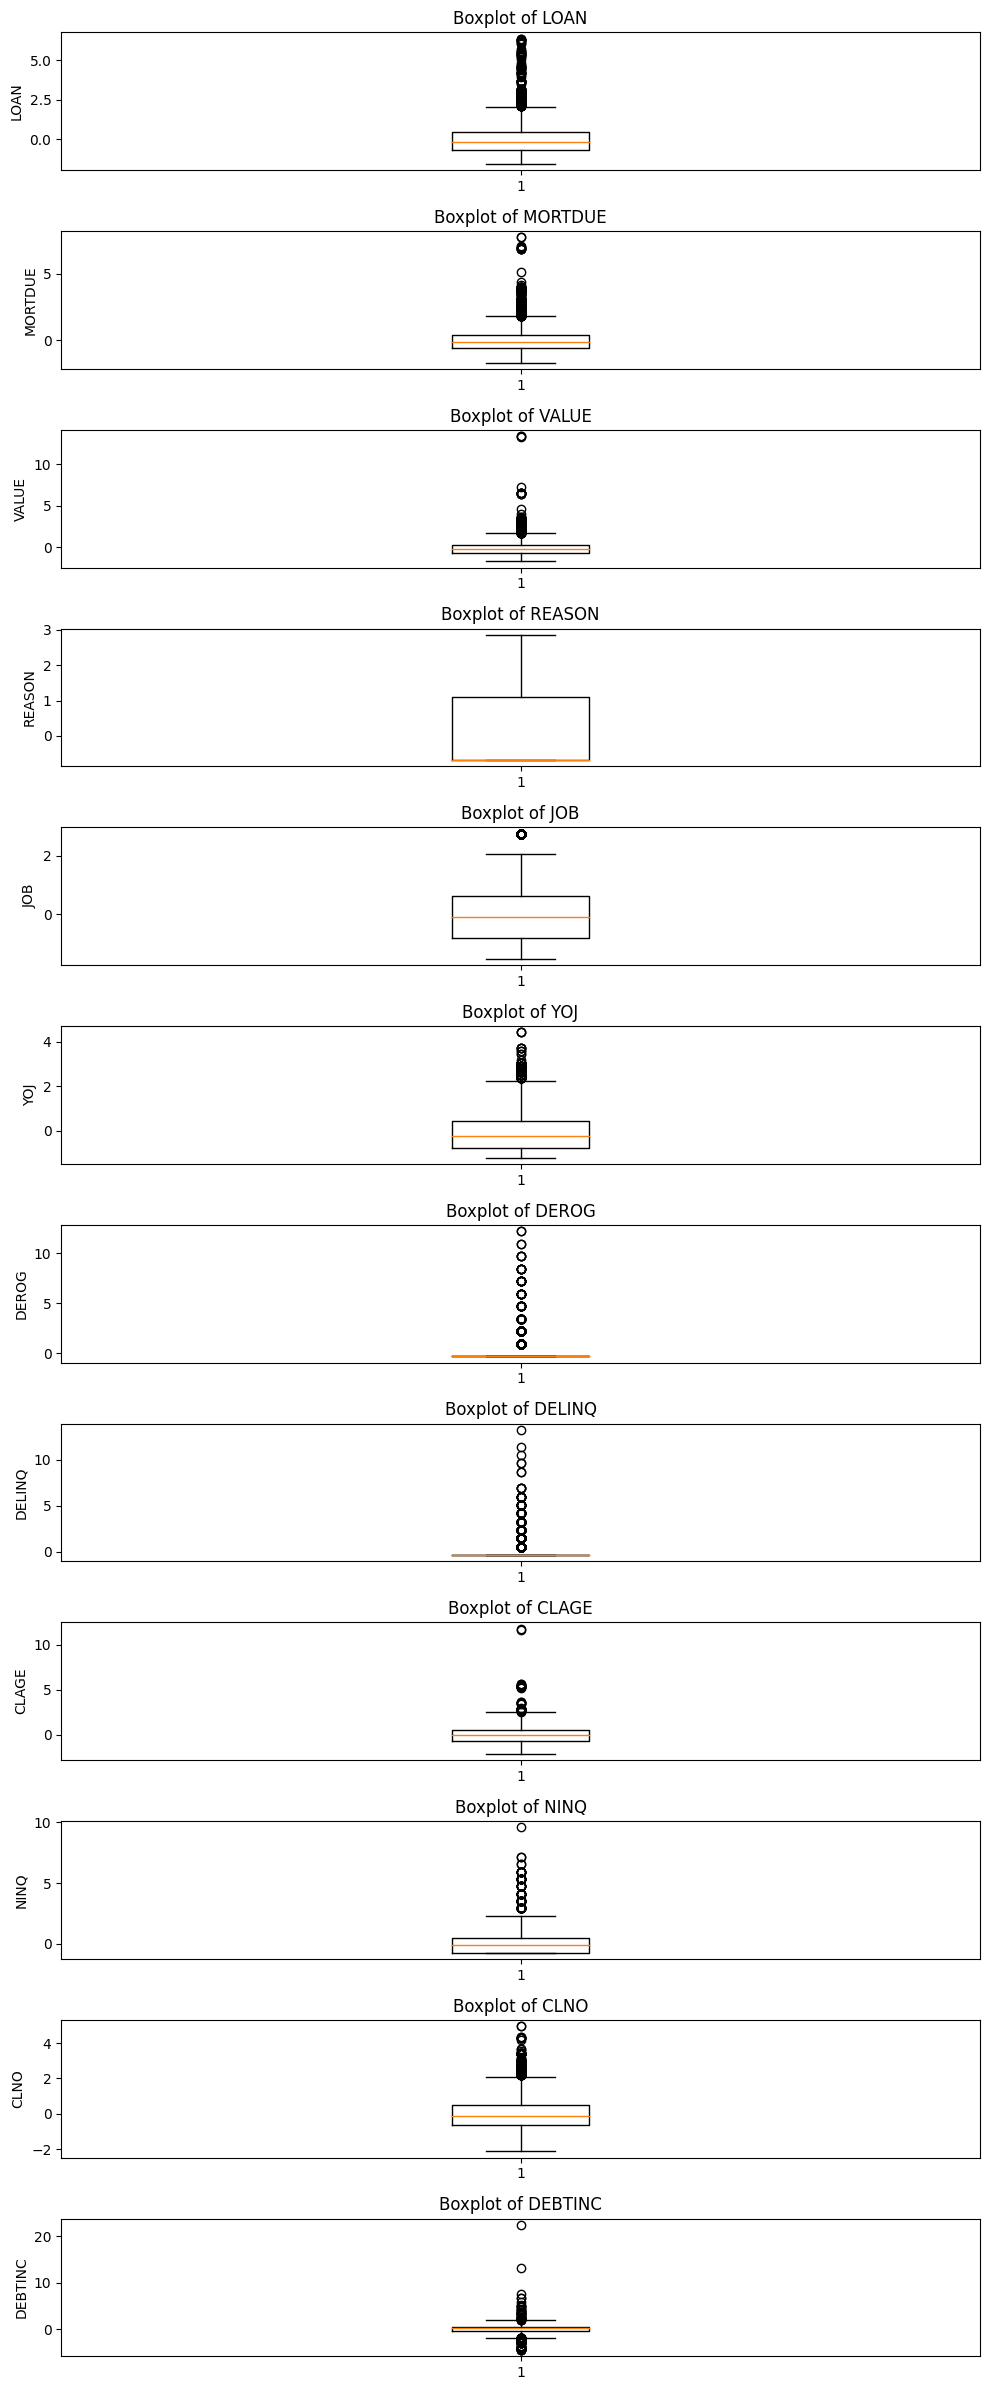

In [ ]:
show_outliers_boxplot(x_train_1)

### BỘ DỮ LIỆU 2: Chiến lược 1
- Bỏ các hàng có từ 4 vị trí null trở lên
- Loại bỏ outlier
- Mã hóa nhãn biến phân loại về dạng số 

In [ ]:
x_train_2, x_test_2, y_train_2, y_test_2 = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
# Bỏ các hàng có từ 4 vị trí null trở lên và Triển khai theo chiến lược 1
x_train_2,y_train_2 = strategy_1(x_train_2,y_train_2)
x_test_2,y_test_2 = strategy_1(x_test_2,y_test_2)
# Loại bỏ ngoại lệ các cột có giá trị skew trung bình là 3
remove_outliers_iqr(x_train_2,y_train_2,['VALUE','DEBTINC'])
remove_outliers_iqr(x_test_2,y_test_2,['VALUE','DEBTINC'])
# LabelEncode
labelencoding_label(x_train_2,2,True)
labelencoding_label(x_test_2,2,False)
# Chuẩn hóa dạng Standard Scaler
x_train_2, y_train_2 = MinMaxScaler_data(x_train_2, y_train_2, 2, True)
x_test_2, y_test_2 = MinMaxScaler_data(x_test_2, y_test_2, 2, False)

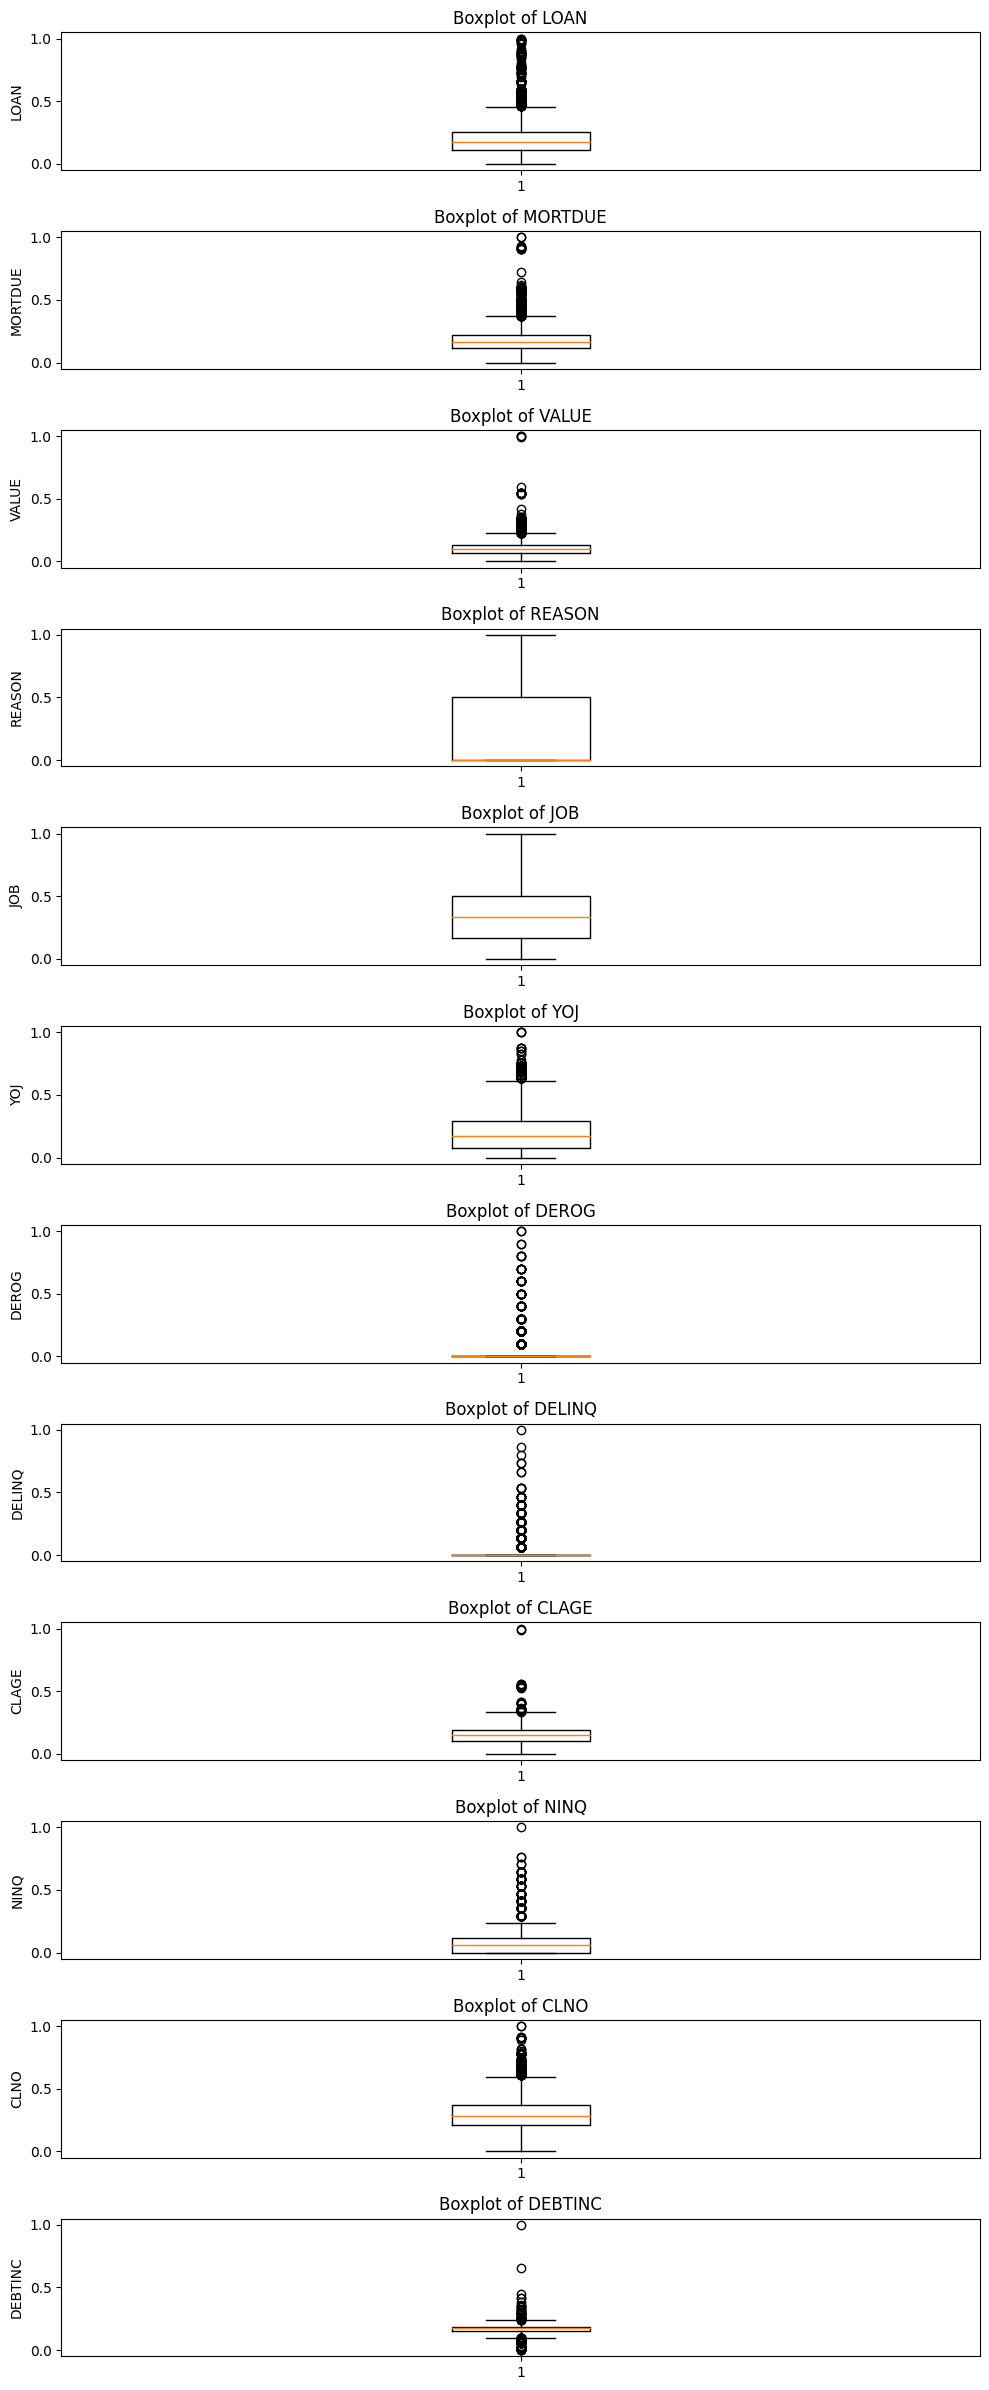

In [ ]:
show_outliers_boxplot(x_train_2)

### BỘ DỮ LIỆU 3: Chiến lược 2
- Không bỏ các hàng có từ 4 vị trí null trở lên
- Loại bỏ outlier
- Mã hóa nhãn biến phân loại về dạng số 
- Chuẩn hóa dữ liệu bằng Standard

In [ ]:
x_train_3, x_test_3, y_train_3, y_test_3 = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
# Không bỏ các hàng có từ 4 vị trí null trở lên và Triển khai theo chiến lược 2
x_train_3,y_train_3 = strategy_2(x_train_3,y_train_3,False)
x_test_3,y_test_3 = strategy_2(x_test_3,y_test_3,False)
# Loại bỏ ngoại lệ các cột có giá trị skew trung bình là 3
remove_outliers_iqr(x_train_3,y_train_3,['VALUE','DEBTINC'])
remove_outliers_iqr(x_test_3,y_test_3,['VALUE','DEBTINC'])
# LabelEncode
labelencoding_label(x_train_3,3,True)
labelencoding_label(x_test_3,3,False)
# Chuẩn hóa dạng Standard Scaler
x_train_3, y_train_3 = standardScaler_data(x_train_3, y_train_3, 3, True)
x_test_3, y_test_3 = standardScaler_data(x_test_3, y_test_3, 3, False)

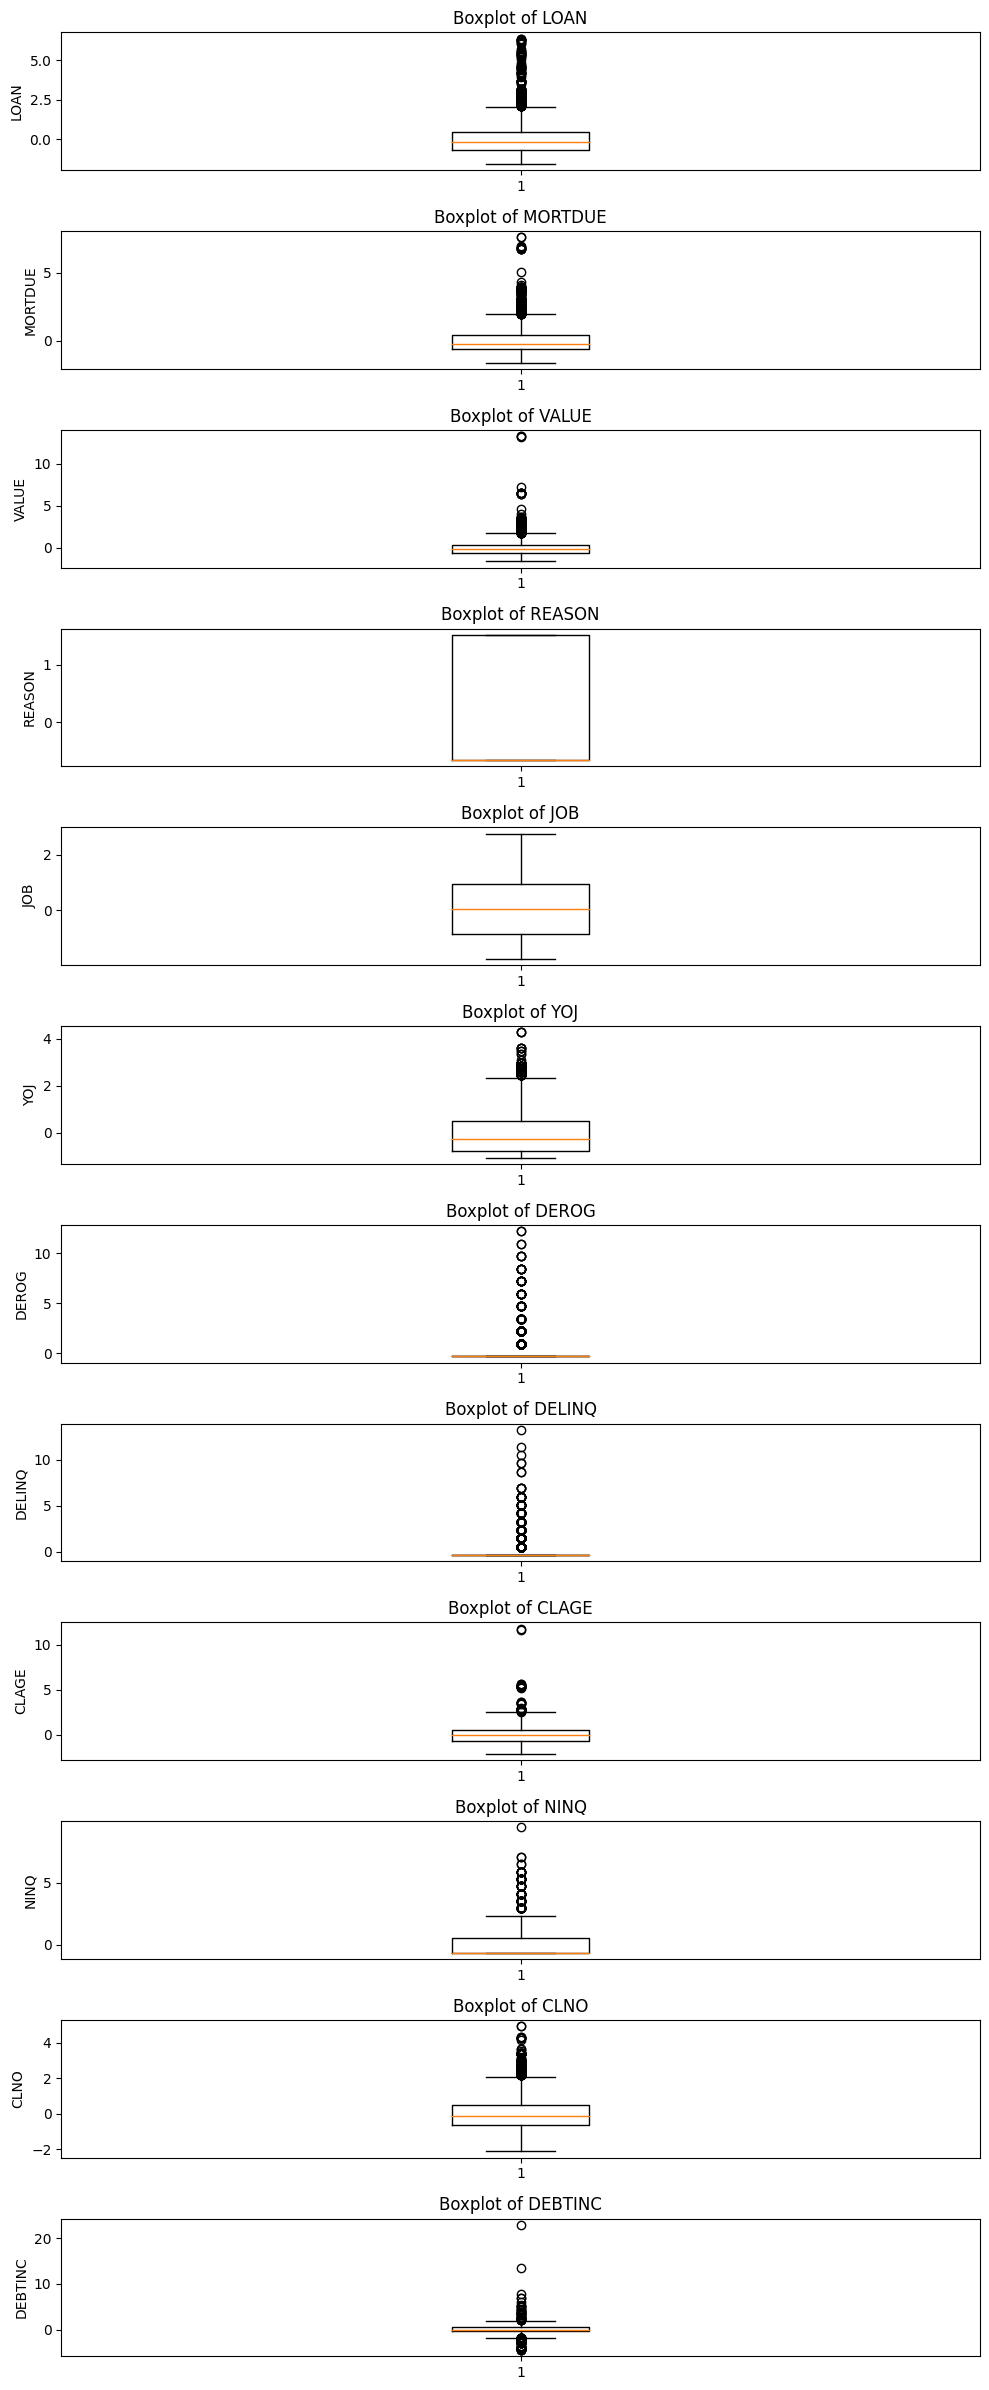

In [ ]:
show_outliers_boxplot(x_train_3)

### BỘ DỮ LIỆU 4: Chiến lược 2
- Bỏ các hàng có từ 4 vị trí null trở lên
- Loại bỏ outlier
- Mã hóa nhãn biến phân loại về dạng số 
- Chuẩn hóa dữ liệu bằng MinMax

In [ ]:
x_train_4, x_test_4, y_train_4, y_test_4 = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
# Bỏ các hàng có từ 4 vị trí null trở lên và Triển khai theo chiến lược 2
x_train_4,y_train_4 = strategy_2(x_train_4,y_train_4,True)
x_test_4,y_test_4 = strategy_2(x_test_4,y_test_4,True)
# Loại bỏ ngoại lệ các cột có giá trị skew trung bình là 3
remove_outliers_iqr(x_train_4,y_train_4,['VALUE','DEBTINC'])
remove_outliers_iqr(x_test_4,y_test_4,['VALUE','DEBTINC'])
# LabelEncode
labelencoding_label(x_train_4,4,True)
labelencoding_label(x_test_4,4,False)
# Chuẩn hóa dạng Standard Scaler
x_train_4, y_train_4 = MinMaxScaler_data(x_train_4, y_train_4, 4, True)
x_test_4, y_test_4 = MinMaxScaler_data(x_test_4, y_test_4, 4, False)

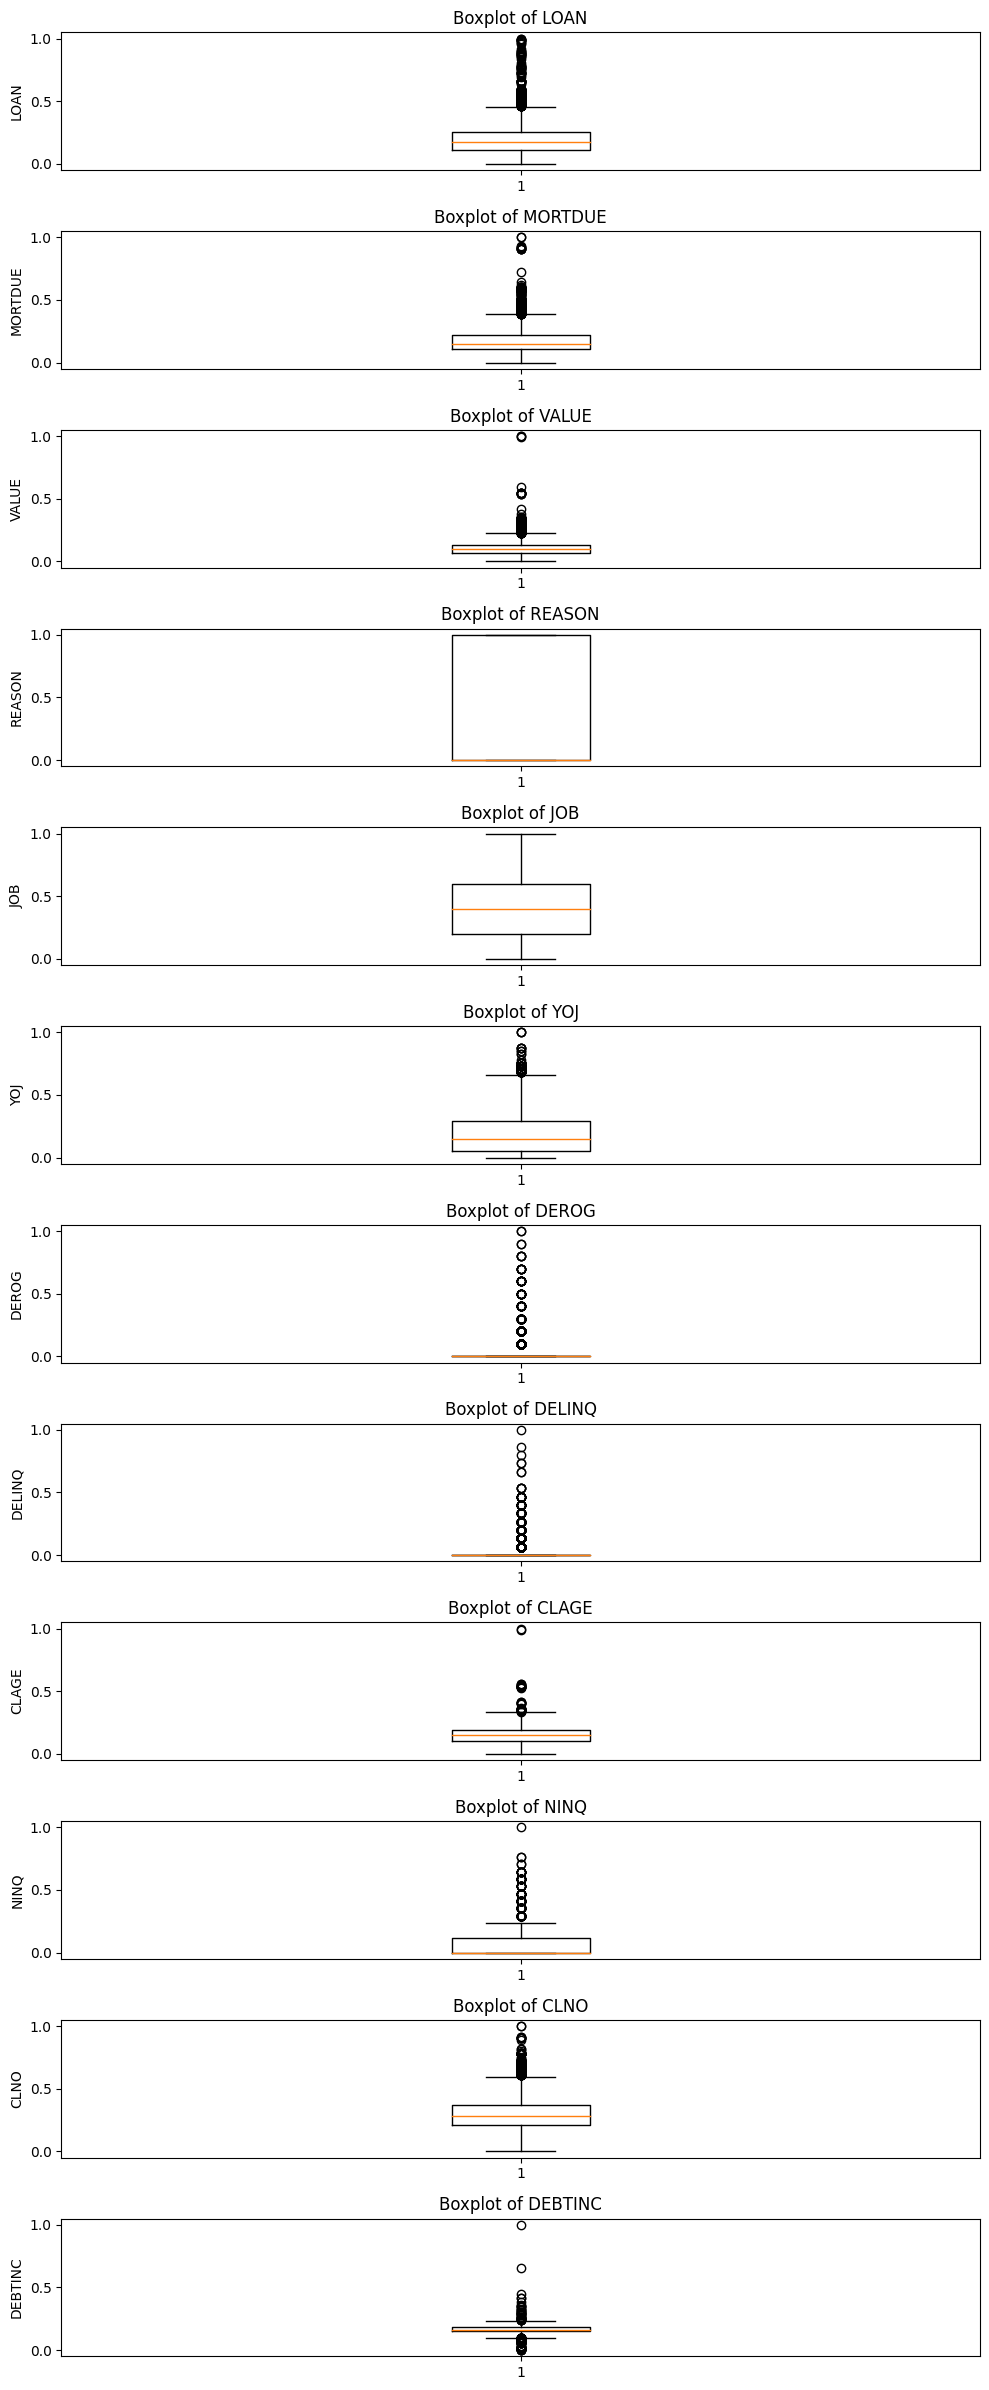

In [ ]:
show_outliers_boxplot(x_train_4)

In [ ]:
def transform(x,y,is_drop_DEBTINC=False,is_dummy = True):
    data = pd.concat([x,y],axis=1)
    data.dropna(axis=0, how='any', inplace=True)
    if is_drop_DEBTINC == True:
      data.drop('DEBTINC', axis=1, inplace=True)
    else:
      # Giả sử 'y' là nhãn của bạn, và bạn muốn thay thế giá trị NaN trong cột DEBTINC cho các hàng mà y == 0
      data.loc[(data['DEBTINC'].isna()) & (y == 0), 'DEBTINC'] = round(data.loc[y == 0, 'DEBTINC'].median(), 0)

      data.loc[(data['DEBTINC'].isna()) & (y == 1), 'DEBTINC'] = round(data.loc[y == 1,'DEBTINC'].median(), 0)
    # one-hot coding
    if is_dummy:
        data = pd.get_dummies(data, columns=['REASON','JOB'])
    y = data['BAD']
    x = data.drop(['BAD'],axis=1)
    return x,y

### BỘ DỮ LIỆU 5:
- Loại bỏ các hàng có dữ liệu thiếu và chọn lọc ra 7 đặc trưng tương quan nhất với biến dự đoán
- Chuyển đổi các cột phân loại thành các cột dạng one-hot encoding
- Mã hóa nhãn biến phân loại về dạng số
- Loại bỏ outlier
- Chuẩn hóa dữ liệu bằng Standard

In [ ]:
x_train_5, x_test_5, y_train_5, y_test_5 = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
x_train_5,y_train_5 = transform(x_train_5,y_train_5)
x_test_5,y_test_5 = transform(x_test_5,y_test_5)
# LabelEncode
labelencoding_label(x_train_5,5,True)
labelencoding_label(x_test_5,5,False)
# Chọn lọc đặc trưng
x_train_5 = Feature_Selection(x_train_5,y_train_5,7)
x_test_5 = x_test_5[x_train_5.columns]
# Chuẩn hóa dạng Standard Scaler
x_train_5, y_train_5 = standardScaler_data(x_train_5, y_train_5, 5, True)
x_test_5, y_test_5 = standardScaler_data(x_test_5, y_test_5, 5, False)

In [ ]:
x_train_5

,LOAN,MORTDUE,VALUE,DEROG,DELINQ,CLAGE,DEBTINC
0,-1.043276,-0.127391,-0.467546,-0.253958,-0.345872,-0.479610,-0.333180
1,0.170577,-0.607690,-0.651662,-0.253958,-0.345872,-1.595167,-0.163140
2,4.752189,2.662705,3.290967,-0.253958,-0.345872,0.550280,-0.670884
3,-0.322266,0.289764,0.049764,-0.253958,-0.345872,-0.850446,0.699973
4,-0.267505,-0.589620,-0.455577,-0.253958,-0.345872,-0.594605,-0.814702
...,...,...,...,...,...,...,...
2684,0.572152,-0.316361,-0.372102,-0.253958,0.860418,-1.198424,0.034865
2685,-0.550434,0.466149,0.282444,-0.253958,-0.345872,-0.218366,0.009299
2686,-0.568687,0.365449,0.119550,-0.253958,-0.345872,0.660170,-0.747290
2687,-0.678208,-0.644471,-0.409095,-0.253958,-0.345872,0.133479,0.130920


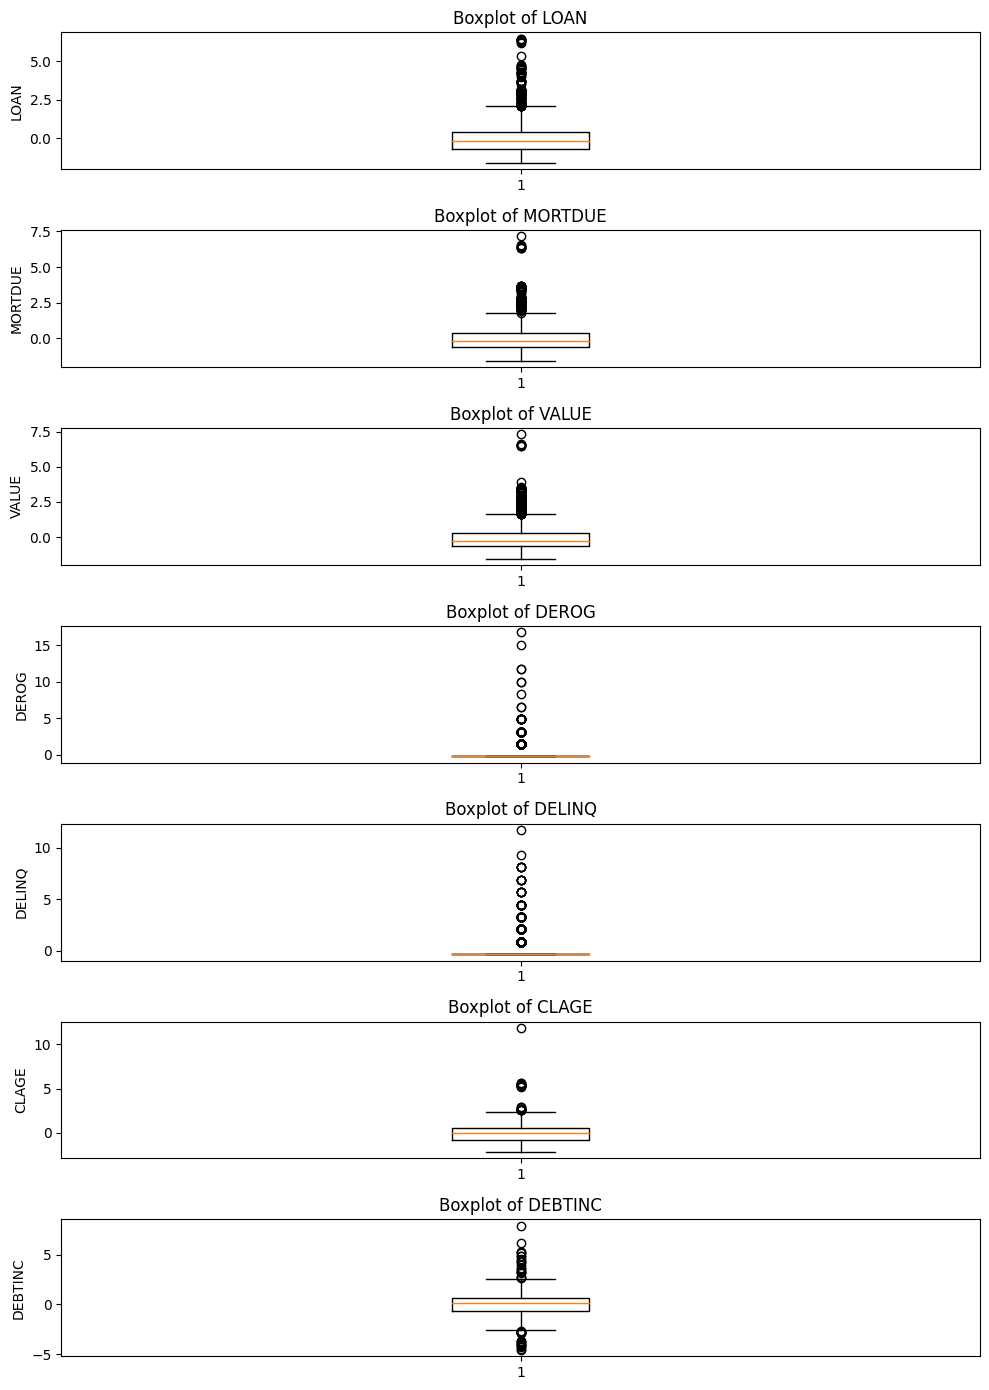

In [ ]:
show_outliers_boxplot(x_train_5)

### BỘ DỮ LIỆU 6:
- Loại bỏ các hàng có dữ liệu thiếu và bỏ cột DEBINT do nhiều dữ liệu thiếu nhất
- Mã hóa nhãn biến phân loại về dạng số 
- Loại bỏ outlier
- Chuẩn hóa dữ liệu bằng Standard

In [ ]:
x_train_6, x_test_6, y_train_6, y_test_6 = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
x_train_6,y_train_6 = transform(x_train_6,y_train_6,True,False)
x_test_6,y_test_6 = transform(x_test_6,y_test_6,True,False)

# LabelEncode
labelencoding_label(x_train_6,6,True)
labelencoding_label(x_test_6,6,False)

# Loại bỏ ngoại lệ cột có skew = 3
remove_outliers_iqr(x_train_6,y_train_6,['VALUE'])
remove_outliers_iqr(x_test_6,y_test_6,['VALUE'])
# Chuẩn hóa dạng Standard Scaler
x_train_6, y_train_6 = standardScaler_data(x_train_6, y_train_6, 6, True)
x_test_6, y_test_6 = standardScaler_data(x_test_6, y_test_6, 6, False)

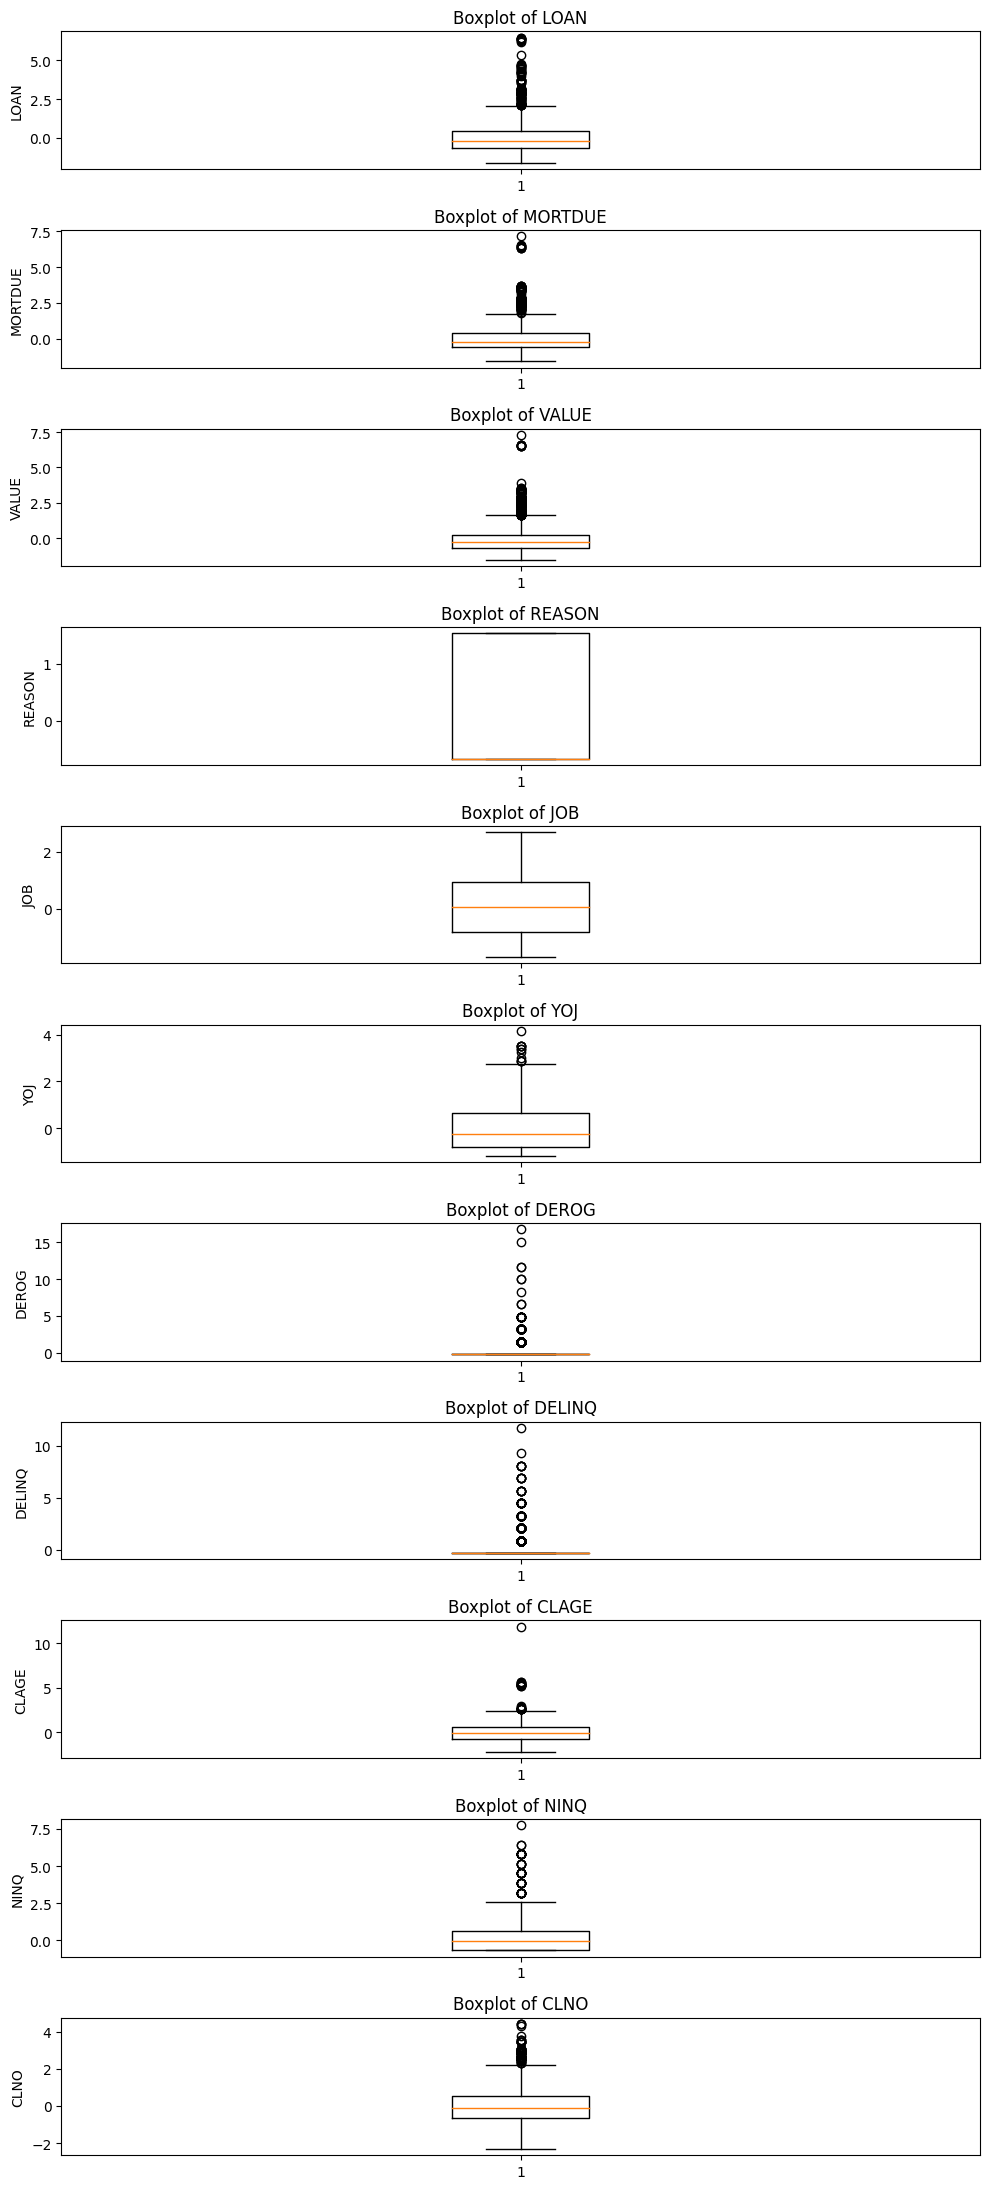

In [ ]:
show_outliers_boxplot(x_train_6)

# Tuning model - Hyperparameter

In [ ]:
# Danh sách các tập dữ liệu huấn luyện và kiểm tra
x_train_list = [x_train_1, x_train_2, x_train_3, x_train_4, x_train_5, x_train_6]
x_test_list = [x_test_1, x_test_2, x_test_3, x_test_4, x_test_5, x_test_6]
y_train_list = [y_train_1, y_train_2, y_train_3, y_train_4, y_train_5, y_train_6]
y_test_list = [y_test_1, y_test_2, y_test_3, y_test_4, y_test_5, y_test_6]

## Logistic Regression

Model 1


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


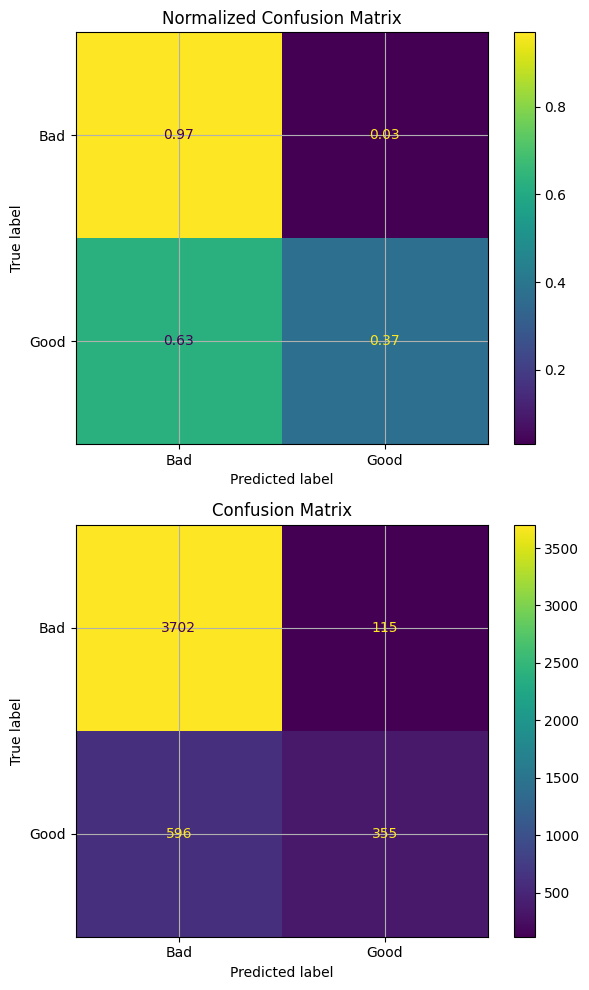

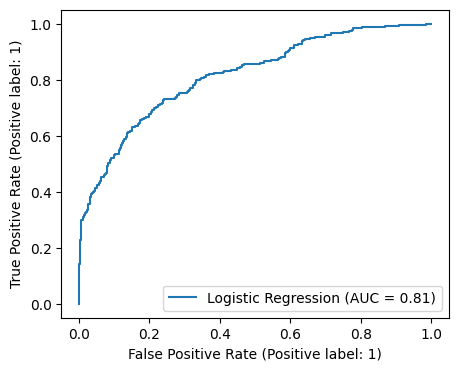

auc              : 0.838809
specificity      : 0.969870
recall           : 0.373293
accuracy         : 0.850882
              precision    recall  f1-score   support

         Bad       0.86      0.97      0.91      3817
        Good       0.76      0.37      0.50       951

    accuracy                           0.85      4768
   macro avg       0.81      0.67      0.71      4768
weighted avg       0.84      0.85      0.83      4768

Model 2
Best parameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


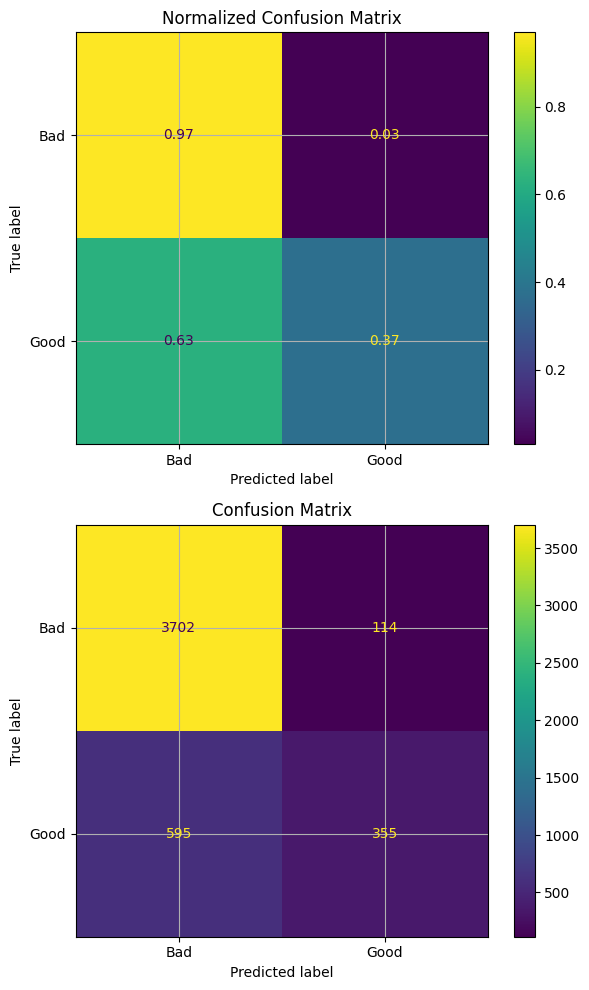

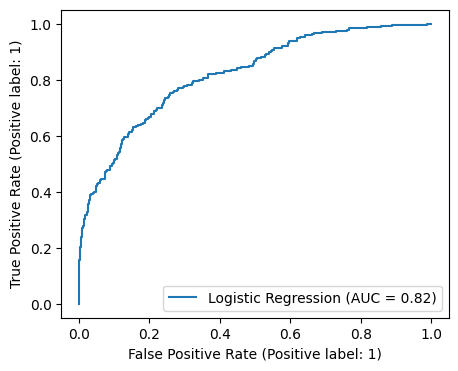

auc              : 0.838733
specificity      : 0.970123
recall           : 0.373684
accuracy         : 0.851237
              precision    recall  f1-score   support

         Bad       0.86      0.97      0.91      3816
        Good       0.76      0.37      0.50       950

    accuracy                           0.85      4766
   macro avg       0.81      0.67      0.71      4766
weighted avg       0.84      0.85      0.83      4766

Model 3
Best parameters: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


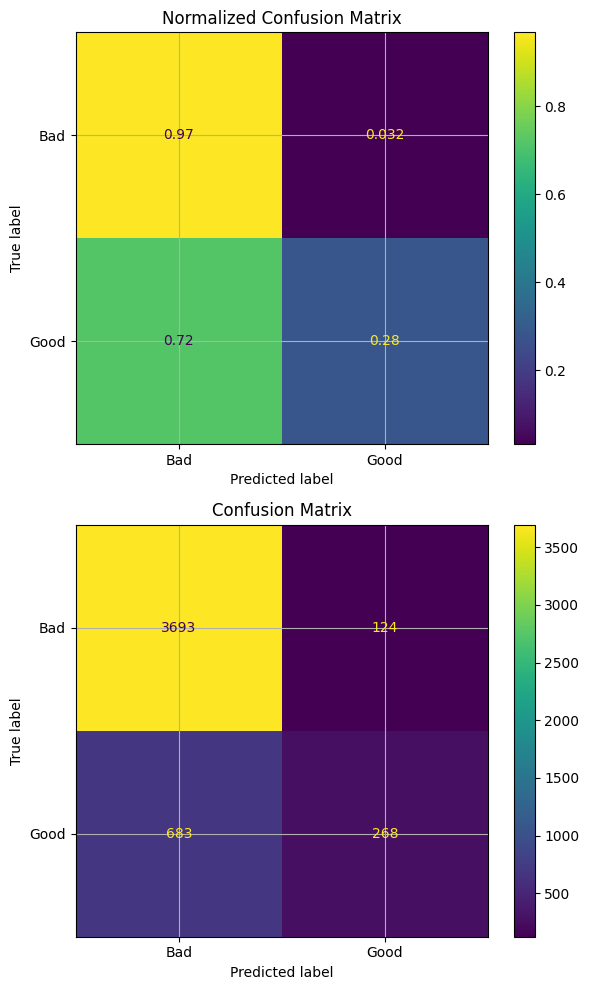

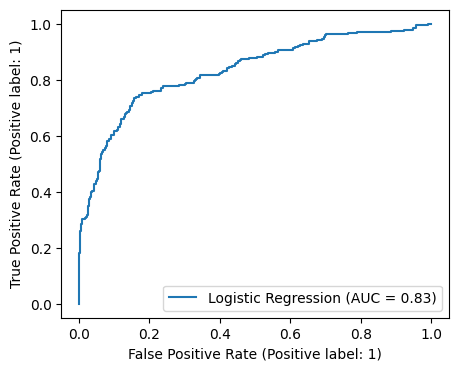

auc              : 0.795339
specificity      : 0.967513
recall           : 0.281802
accuracy         : 0.830745
              precision    recall  f1-score   support

         Bad       0.84      0.97      0.90      3817
        Good       0.68      0.28      0.40       951

    accuracy                           0.83      4768
   macro avg       0.76      0.62      0.65      4768
weighted avg       0.81      0.83      0.80      4768

Model 4
Best parameters: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


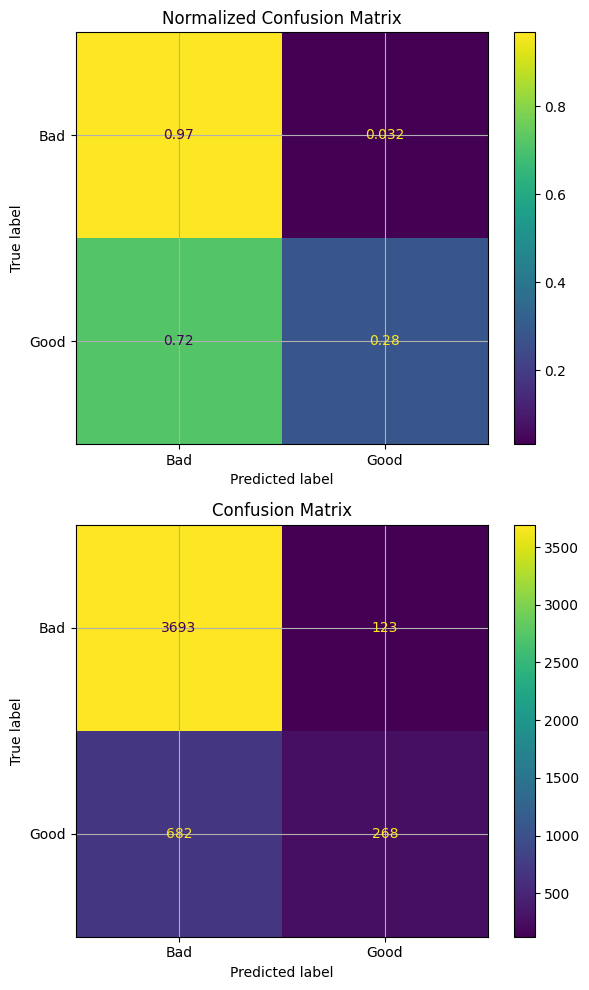

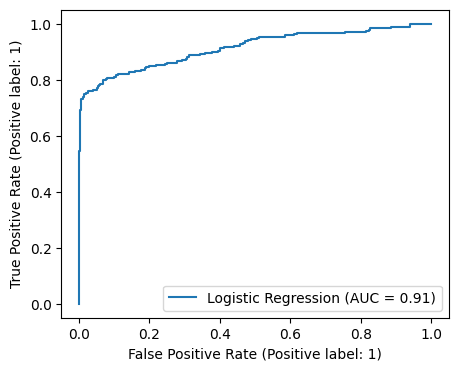

auc              : 0.795475
specificity      : 0.967765
recall           : 0.282105
accuracy         : 0.831093
              precision    recall  f1-score   support

         Bad       0.84      0.97      0.90      3816
        Good       0.69      0.28      0.40       950

    accuracy                           0.83      4766
   macro avg       0.76      0.62      0.65      4766
weighted avg       0.81      0.83      0.80      4766

Model 5
Best parameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'saga'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


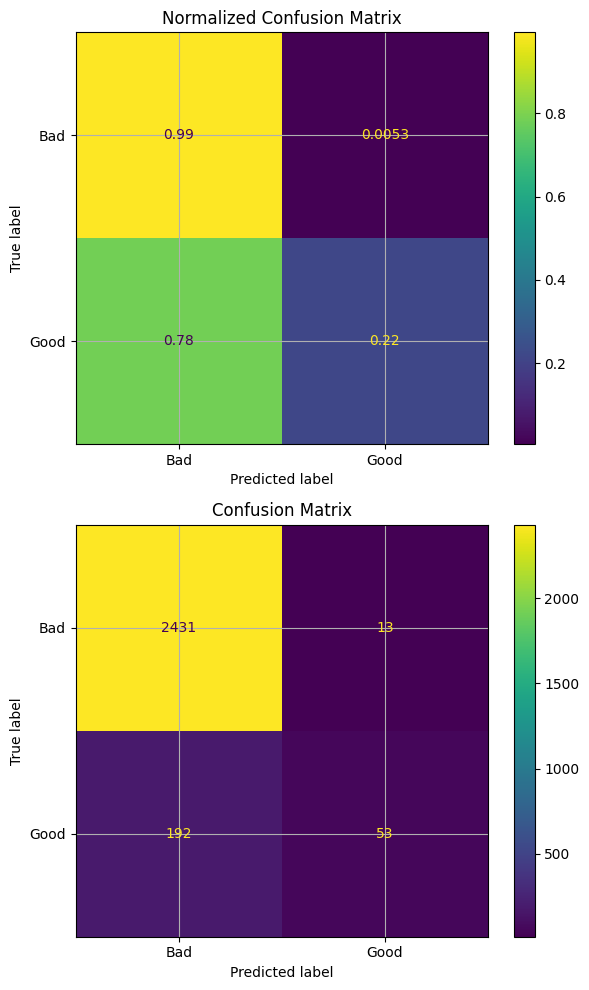

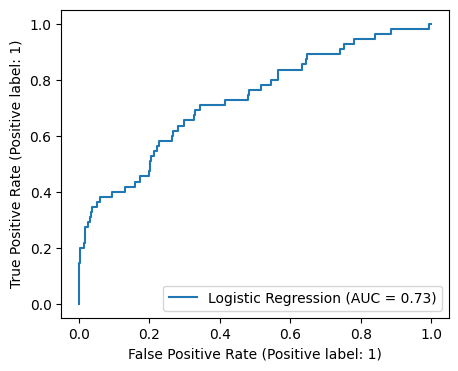

auc              : 0.792491
specificity      : 0.994681
recall           : 0.216327
accuracy         : 0.923763
              precision    recall  f1-score   support

         Bad       0.93      0.99      0.96      2444
        Good       0.80      0.22      0.34       245

    accuracy                           0.92      2689
   macro avg       0.86      0.61      0.65      2689
weighted avg       0.92      0.92      0.90      2689

Model 6
Best parameters: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'saga'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


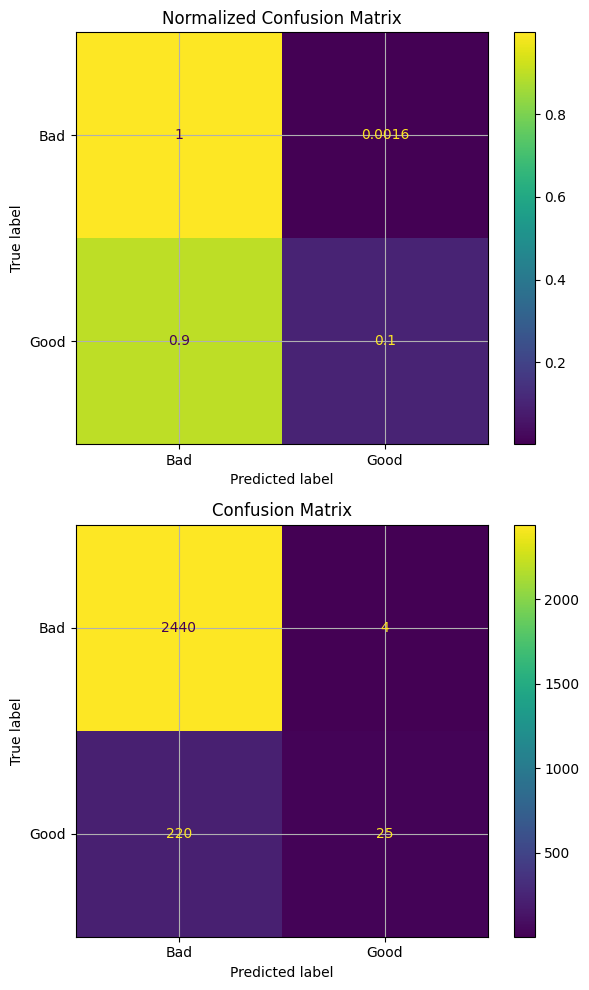

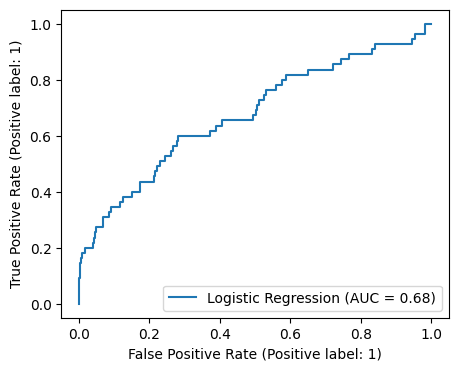

auc              : 0.772751
specificity      : 0.998364
recall           : 0.102041
accuracy         : 0.916699
              precision    recall  f1-score   support

         Bad       0.92      1.00      0.96      2444
        Good       0.86      0.10      0.18       245

    accuracy                           0.92      2689
   macro avg       0.89      0.55      0.57      2689
weighted avg       0.91      0.92      0.89      2689



In [ ]:
lr = LogisticRegression(max_iter=1000)

# Define parameters for GridSearch
parameters = {
    'clf__C': [1e-3, 1e-2, 1e-1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga']
}

# Create final pipeline
pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                           ('clf', lr)])

# Specify scoring metrics
scoring = {
    "auc": "roc_auc",
    "specificity": make_scorer(specificity_score),
    "recall": "recall",
    "accuracy": "accuracy",
}

# Initialize GridSearchCV
gs_lr = GridSearchCV(pipeline, parameters, cv=5, scoring=scoring, refit="auc", n_jobs=-1)

# Fit the model and evaluate it
for i in range(6):
    print(f'Model {i+1}')

    # Fitting the model to the training data
    gs_lr.fit(x_train_list[i], y_train_list[i])
    print(f'Best parameters:', gs_lr.best_params_)

    # Perform cross-validation
    lr_scores = cross_validate(gs_lr.best_estimator_, x_train_list[i], y_train_list[i], cv=5, n_jobs=-1, verbose=1,
                               return_train_score=True, scoring=scoring)

    # Make cross-validated predictions
    lr_preds = cross_val_predict(gs_lr.best_estimator_, x_train_list[i], y_train_list[i], cv=5, n_jobs=-1)

    # Plot confusion matrices
    f, axs = plt.subplots(2, 1, figsize=(6, 10))

    ConfusionMatrixDisplay.from_predictions(y_train_list[i], lr_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize="true",
                                        ax=axs[0])
    axs[0].set_title('Normalized Confusion Matrix')
    axs[0].grid()

    ConfusionMatrixDisplay.from_predictions(y_train_list[i], lr_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize=None,
                                        ax=axs[1])
    axs[1].set_title('Confusion Matrix')
    axs[1].grid()

    plt.tight_layout()
    plt.show()
    f, axs = plt.subplots(1, 1, figsize=(5, 4))
    RocCurveDisplay.from_estimator(gs_lr.best_estimator_, x_test_list[i], y_test_list[i],
                               name="Logistic Regression",
                               ax=axs);
    plt.show()
    time.sleep(1)  # Optional delay

    # Print the average cross-validation scores
    for score in scoring:
        print(f"{score:<17}: {np.mean(lr_scores['test_' + score]):.6f}")
    print(classification_report(y_train_list[i], lr_preds, target_names=['Bad', 'Good']))

# Lựa chọn mô hình

## Phân tích kết quả

### Model 1 và Model 2
- **AUC**: 0.838809 (Model 1), 0.838733 (Model 2)
- **Specificity**: Khoảng 0.97 (khả năng phát hiện đúng nhóm "Bad" là rất cao)
- **Recall**: Khoảng 0.373 (khả năng phát hiện đúng nhóm "Good" tương đối thấp)
- **Accuracy**: Khoảng 0.85
- **Precision**: 0.76 (nhóm "Good"), 0.86 (nhóm "Bad")
- **F1-score**: 0.50 (nhóm "Good"), 0.91 (nhóm "Bad")

=> Cả hai mô hình này đều có kết quả tương tự, với độ chính xác cao, nhưng khả năng phát hiện nhóm "Good" (Recall) khá hạn chế.

### Model 3 và Model 4
- **AUC**: Khoảng 0.795
- **Specificity**: Khoảng 0.97
- **Recall**: Khoảng 0.28 (rất thấp đối với nhóm "Good")
- **Accuracy**: Khoảng 0.83
- **Precision**: 0.69 (nhóm "Good"), 0.84 (nhóm "Bad")
- **F1-score**: 0.40 (nhóm "Good"), 0.90 (nhóm "Bad")

=> Hiệu suất của hai mô hình này thấp hơn Model 1 và 2, đặc biệt là Recall cho nhóm "Good" rất thấp, cho thấy mô hình không nhạy với nhóm này.

### Model 5 và Model 6
- **AUC**: 0.792491 (Model 5), 0.802462 (Model 6)
- **Specificity**: Khoảng 0.995
- **Recall**: 0.216327 (Model 5), 0.151020 (Model 6)
- **Accuracy**: Khoảng 0.92
- **Precision**: 0.76 đến 0.80 cho nhóm "Good", 0.92 đến 0.93 cho nhóm "Bad"
- **F1-score**: 0.34 (Model 5), 0.25 (Model 6) cho nhóm "Good"

=> Dù độ chính xác tổng thể cao, khả năng phát hiện nhóm "Good" của hai mô hình này là rất thấp, với Recall chỉ từ 0.15 đến 0.22.

## Lựa chọn mô hình
Dựa trên kết quả phân tích, **Model 1** và **Model 2** là hai mô hình có hiệu suất tốt nhất. Chúng có AUC cao nhất và độ chính xác tốt nhất với khả năng phát hiện nhóm "Good" tốt hơn so với các mô hình còn lại.

- **Chọn Model 1 hoặc Model 2** để triển khai do hiệu suất tốt hơn trong việc phát hiện các trường hợp "Good" và có độ chính xác tổng thể cao hơn.


## Random Forest


Model 1
Best parameters: {'max_depth': 8, 'min_samples_split': 3, 'n_estimators': 200}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


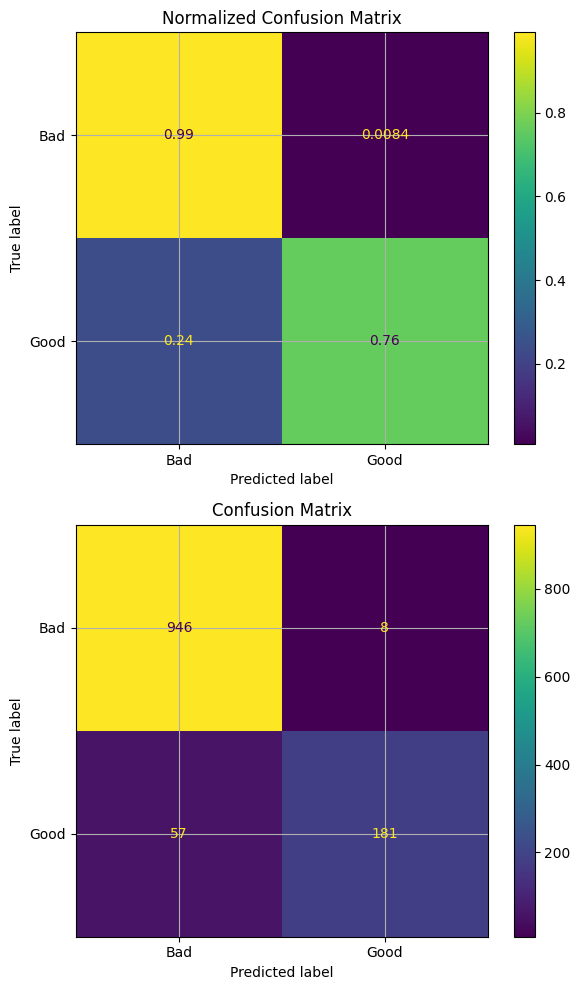

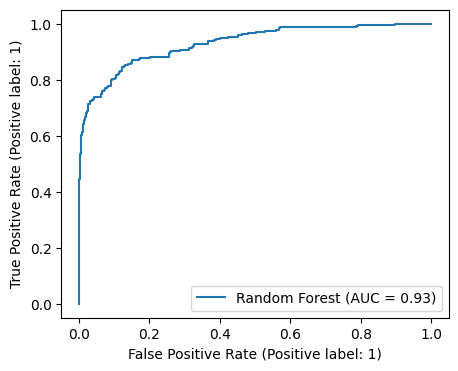

auc              : 0.949888
specificity      : 0.991618
recall           : 0.760727
accuracy         : 0.945473
              precision    recall  f1-score   support

         Bad       0.94      0.99      0.97       954
        Good       0.96      0.76      0.85       238

    accuracy                           0.95      1192
   macro avg       0.95      0.88      0.91      1192
weighted avg       0.95      0.95      0.94      1192

Model 2
Best parameters: {'max_depth': 8, 'min_samples_split': 3, 'n_estimators': 200}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


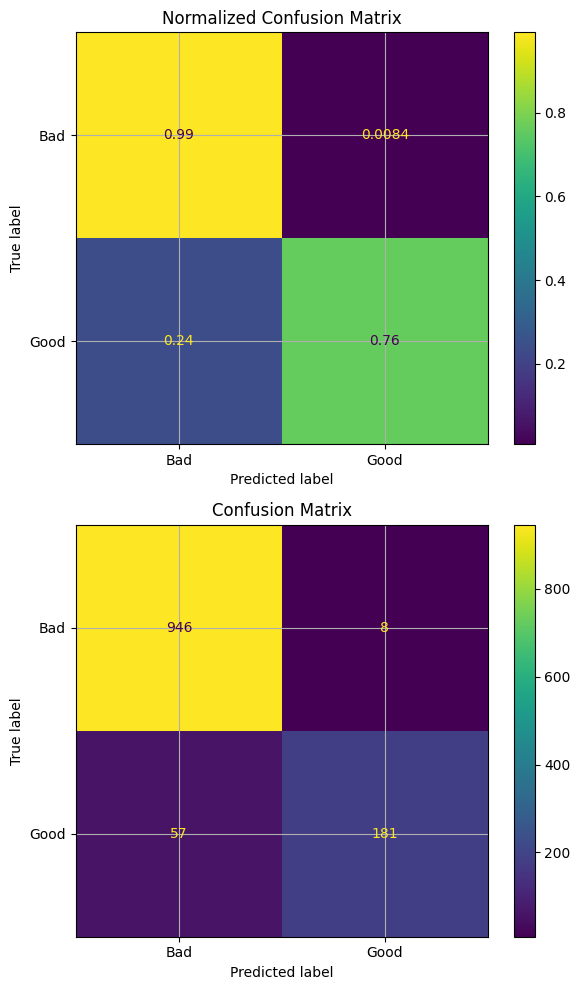

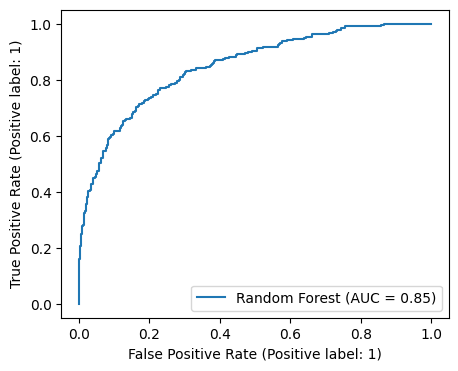

auc              : 0.949120
specificity      : 0.991618
recall           : 0.760727
accuracy         : 0.945473
              precision    recall  f1-score   support

         Bad       0.94      0.99      0.97       954
        Good       0.96      0.76      0.85       238

    accuracy                           0.95      1192
   macro avg       0.95      0.88      0.91      1192
weighted avg       0.95      0.95      0.94      1192

Model 3
Best parameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 200}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


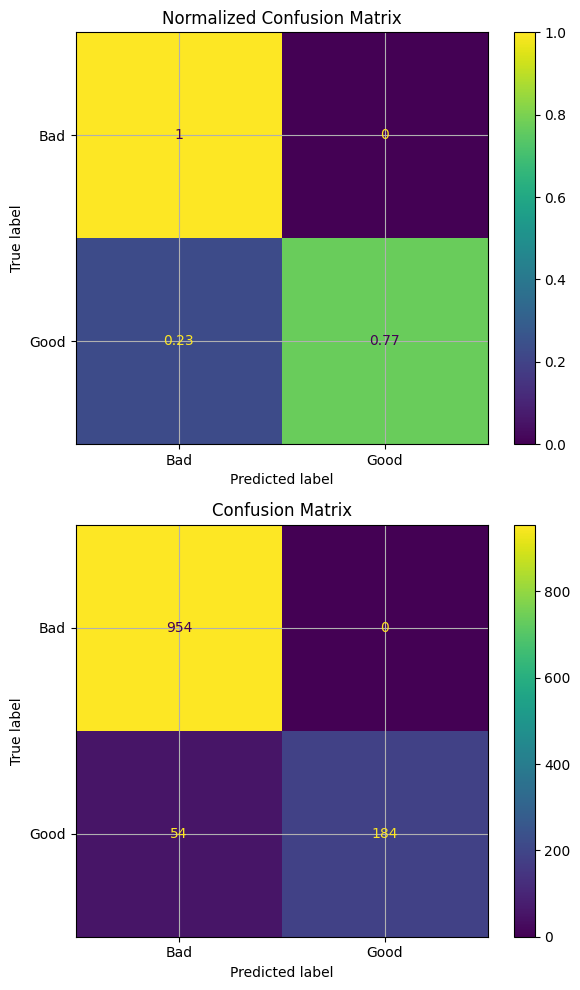

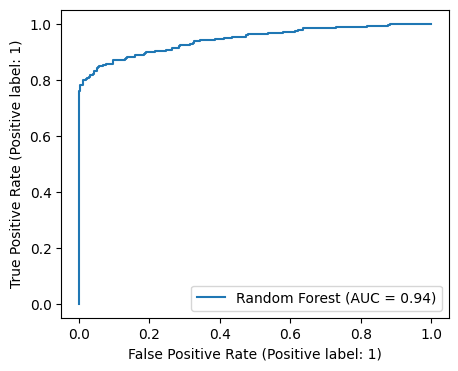

auc              : 0.952753
specificity      : 1.000000
recall           : 0.773227
accuracy         : 0.954689
              precision    recall  f1-score   support

         Bad       0.95      1.00      0.97       954
        Good       1.00      0.77      0.87       238

    accuracy                           0.95      1192
   macro avg       0.97      0.89      0.92      1192
weighted avg       0.96      0.95      0.95      1192

Model 4
Best parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


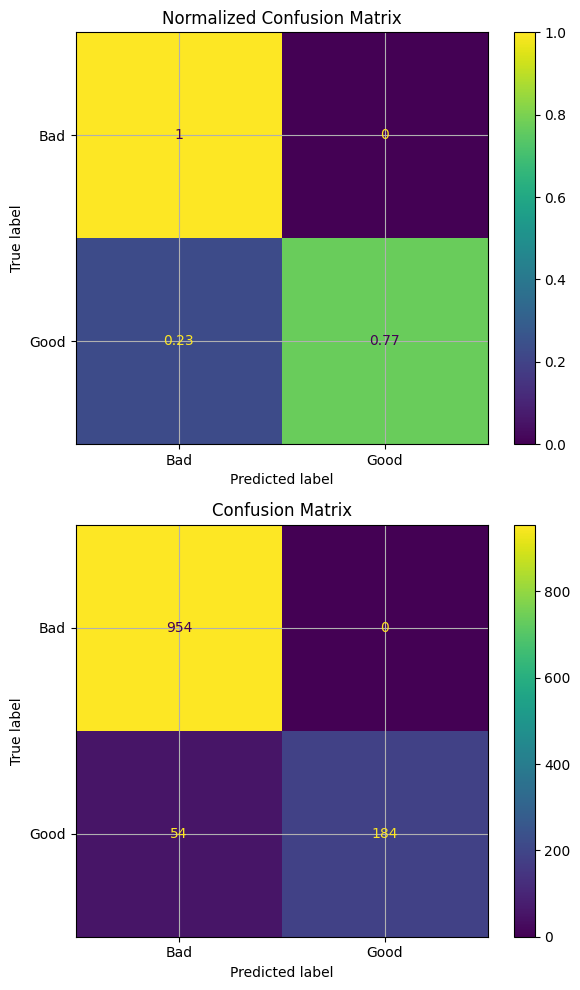

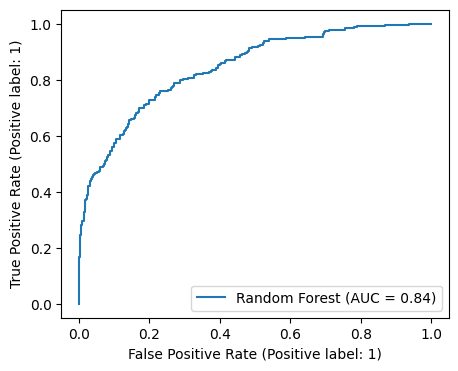

auc              : 0.947049
specificity      : 1.000000
recall           : 0.773227
accuracy         : 0.954689
              precision    recall  f1-score   support

         Bad       0.95      1.00      0.97       954
        Good       1.00      0.77      0.87       238

    accuracy                           0.95      1192
   macro avg       0.97      0.89      0.92      1192
weighted avg       0.96      0.95      0.95      1192

Model 5
Best parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


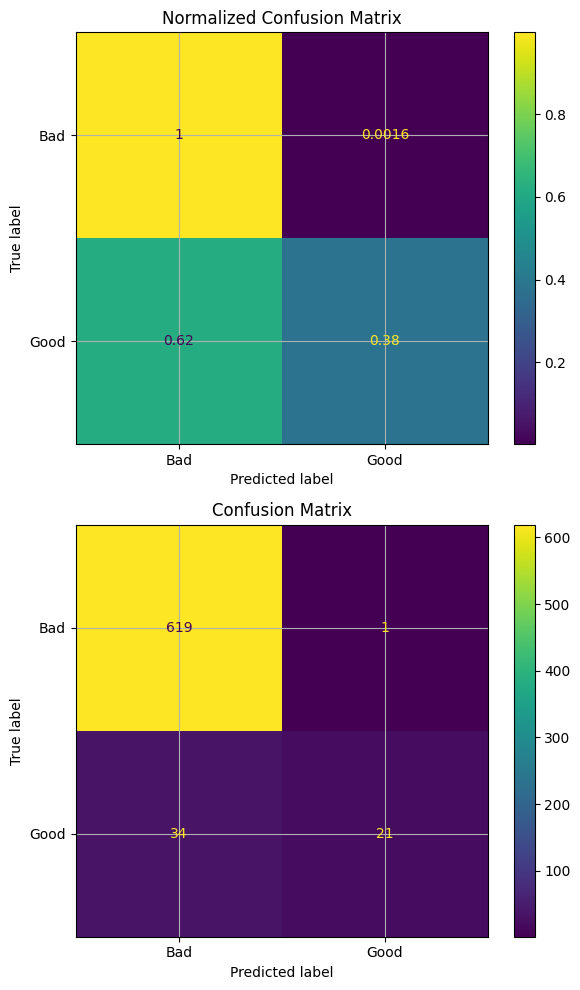

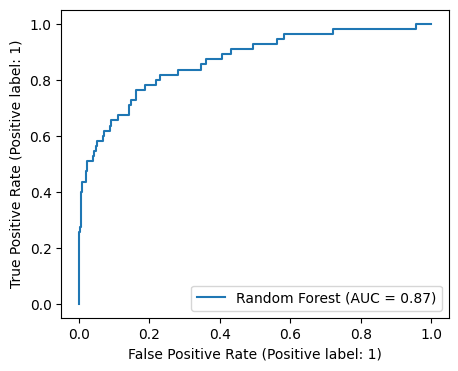

auc              : 0.789589
specificity      : 0.998387
recall           : 0.381818
accuracy         : 0.948148
              precision    recall  f1-score   support

         Bad       0.95      1.00      0.97       620
        Good       0.95      0.38      0.55        55

    accuracy                           0.95       675
   macro avg       0.95      0.69      0.76       675
weighted avg       0.95      0.95      0.94       675

Model 6
Best parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 200}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


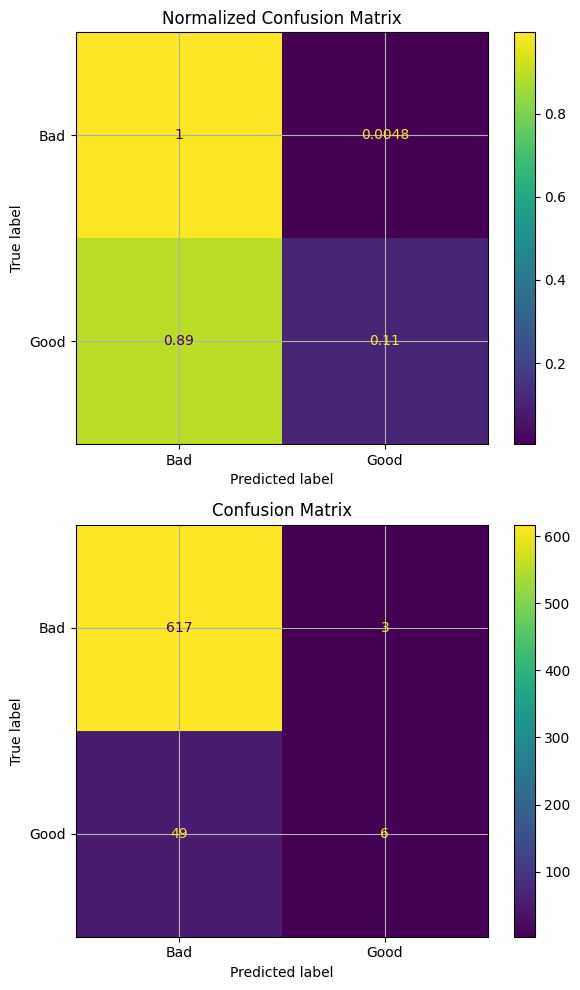

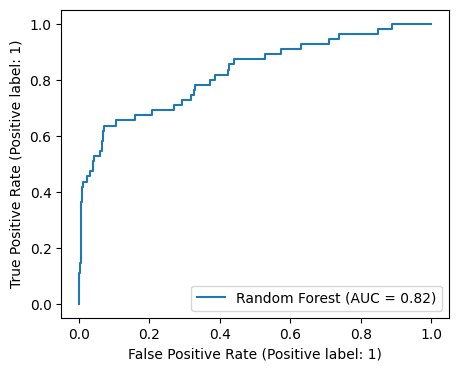

auc              : 0.767595
specificity      : 0.995161
recall           : 0.109091
accuracy         : 0.922963
              precision    recall  f1-score   support

         Bad       0.93      1.00      0.96       620
        Good       0.67      0.11      0.19        55

    accuracy                           0.92       675
   macro avg       0.80      0.55      0.57       675
weighted avg       0.91      0.92      0.90       675



In [ ]:
rf = RandomForestClassifier(random_state=99)

parameters = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [2, 3, 4, 5],
}

scoring = {
    "auc": "roc_auc",
    "specificity": make_scorer(specificity_score),
    "recall": "recall",
    "accuracy": "accuracy",
}

gs_rf = GridSearchCV(rf, parameters, cv=5, scoring=scoring, refit="auc", n_jobs=-1)

for i in range(6):
    print(f'Model {i+1}')

    gs_rf.fit(x_train_list[i], y_train_list[i])
    print(f'Best parameters:', gs_rf.best_params_)

    rf_scores = cross_validate(gs_rf.best_estimator_, x_test_list[i], y_test_list[i], cv=5, n_jobs=-1, verbose=1,
                               return_train_score=True, scoring=scoring)

    rf_preds = cross_val_predict(gs_rf.best_estimator_, x_test_list[i], y_test_list[i], cv=5, n_jobs=-1)

    f, axs = plt.subplots(2, 1, figsize=(6, 10))

    ConfusionMatrixDisplay.from_predictions(y_test_list[i], rf_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize="true",
                                        ax=axs[0])
    axs[0].set_title('Normalized Confusion Matrix')
    axs[0].grid()

    ConfusionMatrixDisplay.from_predictions(y_test_list[i], rf_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize=None,
                                        ax=axs[1])
    axs[1].set_title('Confusion Matrix')
    axs[1].grid()

    plt.tight_layout()
    plt.show()

    # Plot ROC Curve
    f, axs = plt.subplots(1, 1, figsize=(5, 4))
    RocCurveDisplay.from_estimator(gs_rf.best_estimator_, x_test_list[i], y_test_list[i],
                                   name="Random Forest",
                                   ax=axs)
    plt.show()
    time.sleep(1)  # Optional delay

    for score in scoring:
        print(f"{score:<17}: {np.mean(rf_scores['test_' + score]):.6f}")

    print(classification_report(y_test_list[i], rf_preds, target_names=['Bad', 'Good']))


## Nhận xét:
  - **Model 1 và Model 2**
    - **AUC**: 0.949888 (Model 1), 0.949120 (Model 2)
    - **Specificity**: 0.991618 cho cả hai mô hình (khả năng phát hiện đúng nhóm "Bad" là rất cao)
    - **Recall**: 0.760727 cho cả hai mô hình (khả năng phát hiện đúng nhóm "Good" là khá tốt)
    - **Accuracy**: 0.945473 cho cả hai mô hình
    - **Precision**: 0.96 (nhóm "Good"), 0.94 (nhóm "Bad")
    - **F1-score**: 0.85 (nhóm "Good"), 0.97 (nhóm "Bad")
  
    Cả hai mô hình này có hiệu suất rất cao, với AUC gần 0.95, độ chính xác cao, và khả năng phát hiện nhóm "Good" tốt.
  
  - **Model 3 và Model 4**
    - **AUC**: 0.952753 (Model 3), 0.947049 (Model 4)
    - **Specificity**: 1.000000 cho cả hai mô hình (rất tốt trong việc phát hiện nhóm "Bad")
    - **Recall**: 0.773227 cho cả hai mô hình (khả năng phát hiện đúng nhóm "Good" là cao)
    - **Accuracy**: 0.954689 cho cả hai mô hình
    - **Precision**: 1.00 (nhóm "Good"), 0.95 (nhóm "Bad")
    - **F1-score**: 0.87 (nhóm "Good"), 0.97 (nhóm "Bad")
  
    Model 3 và Model 4 có AUC và Recall cao hơn một chút so với Model 1 và 2, đặc biệt là khả năng phát hiện nhóm "Good".
  
  - **Model 5 và Model 6**
    - **AUC**: 0.789589 (Model 5), 0.767595 (Model 6)
    - **Specificity**: 0.998387 (Model 5), 0.995161 (Model 6)
    - **Recall**: 0.381818 (Model 5), 0.109091 (Model 6)
    - **Accuracy**: 0.948148 (Model 5), 0.922963 (Model 6)
    - **Precision**: 0.95 (nhóm "Good"), 0.95 (nhóm "Bad") cho Model 5; 0.67 (nhóm "Good"), 0.93 (nhóm "Bad") cho Model 6
    - **F1-score**: 0.55 (Model 5), 0.19 (Model 6) cho nhóm "Good"
  
    Hiệu suất của Model 5 và Model 6 thấp hơn đáng kể so với các mô hình khác, đặc biệt là khả năng phát hiện nhóm "Good" rất thấp.
  
- **Kết luận**  
  Dựa trên kết quả phân tích, **Model 3** là mô hình có hiệu suất tốt nhất với AUC cao nhất, độ chính xác tốt và khả năng phát hiện nhóm "Good" cao hơn các mô hình còn lại.


# Tính điểm tín dụng cho tập test

In [ ]:
def compute_credit_score(p):
    factor = 25 / np.log(2)
    offset = 600 - factor * np.log(50)
    val = (1-p) / p
    score = offset + factor * np.log(val)
    return round(score, 2)

### Logistic Regression

Mô hình 1

In [ ]:
model = LogisticRegression(C= 0.1, penalty= 'l2', solver= 'liblinear')
model.fit(x_train_1, y_train_1)
pred_prob_test = model.predict_proba(x_test_1)[:,1]
test = x_test_1.copy()
test["Proba"] = pred_prob_test
test["Score"] = test["Proba"].apply(lambda x: compute_credit_score(x))

In [ ]:
test['Score'].max()

707.66

In [ ]:
test['Score'].min()

45.25

Mô hình 5

In [ ]:
test1 = x_test_5.copy()
model2 = LogisticRegression(C= 0.1, penalty= 'l2', solver= 'saga')
model2.fit(x_train_5, y_train_5)
pred_prob_test = model2.predict_proba(x_test_5)[:,1]
test1["Proba"] = pred_prob_test
test1["Score"] = test1["Proba"].apply(lambda x: compute_credit_score(x))

In [ ]:
test1['Score'].max()

712.87

In [ ]:
test1['Score'].min()

229.13

### Random Forest

Mô hình 3

In [ ]:
test2 = x_test_3.copy()
model3 = RandomForestClassifier(max_depth= 8, min_samples_split= 5, n_estimators= 200)
model3.fit(x_train_3, y_train_3)
pred_prob_test = model3.predict_proba(x_test_3)[:,1]
test2["Proba"] = pred_prob_test
test2["Score"] = test2["Proba"].apply(lambda x: compute_credit_score(x))

In [ ]:
test2['Score'].max()

592.89

In [ ]:
test2['Score'].min()

382.14